### The IT services were modeled through graph technologies to get dynamic environments. There is NEO4J (graph database) where are all relationships between schools and students, teacher and schools and Cetera. All transactions are saving into the MongoDB (document database) throughout the learning process
### Connecting to NEO4J database and getting data from connecting to shells of these databases.

In [1]:
from neo4j import GraphDatabase, basic_auth
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=basic_auth('neo4j', '123'))

In [3]:
%reload_ext autoreload
%autoreload 2

import ast # str to dict
from pymongo import MongoClient
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from pylab import rcParams
from datetime import datetime
#import nxneo4j as nx
from pymongo import MongoClient
from datetime import datetime
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from IPython.display import Image

convDate = lambda x: datetime.fromtimestamp(int(x)/1000) if not pd.isnull(x) else x

#import networkx as nx_draw

%matplotlib inline
def query_neo4j_db(query_get, gr=False):
    """
    performs query into graph database and returns results
    :param query_: string of cypher query
    :return: result dictionary
    """
    if driver:
        with driver.session() as session_:
            if gr:
                res = session_.run(query_get).get_graph()
            else:    
                res = session_.run(query_get)
            session_.close()
            return res
    else:
        return None
    
def get_number_of_nodes():
    """
    returns number of nodes in graph
    :return: number of nodes (int)
    """
    query_get = "MATCH (n) RETURN count(*) as n"
    results = query_neo4j_db(query_get)
    n = 0
    if results:
        for record_ in results:
            n = record_["n"]
    return n

def get_number_of_relations():
    """
    returns number of relations in graph
    :return: number of relations (int)
    """
    query_ = "MATCH (n)-[r]->() RETURN COUNT(r) as n"
    results = query_neo4j_db(query_)
    n = 0
    if results:
        for record_ in results:
            n = record_["n"]
    return n

### we could observe all labels of nodes

+--------------+---------+
| label        |   count |
|--------------+---------|
| Banner       |       6 |
| Bookshelf    |       9 |
| Badge        |      20 |
| ReadersOrg   |      66 |
| Collection   |     119 |
| Avatar       |     175 |
| Category     |     247 |
| ReadersGroup |    1172 |
| Book         |    1182 |
| Publication  |    1208 |
| Resource     |    1301 |
| Suggestion   |   11342 |
| User         |   12313 |
| Identity     |   13485 |
| MFUpload     |   92114 |
+--------------+---------+


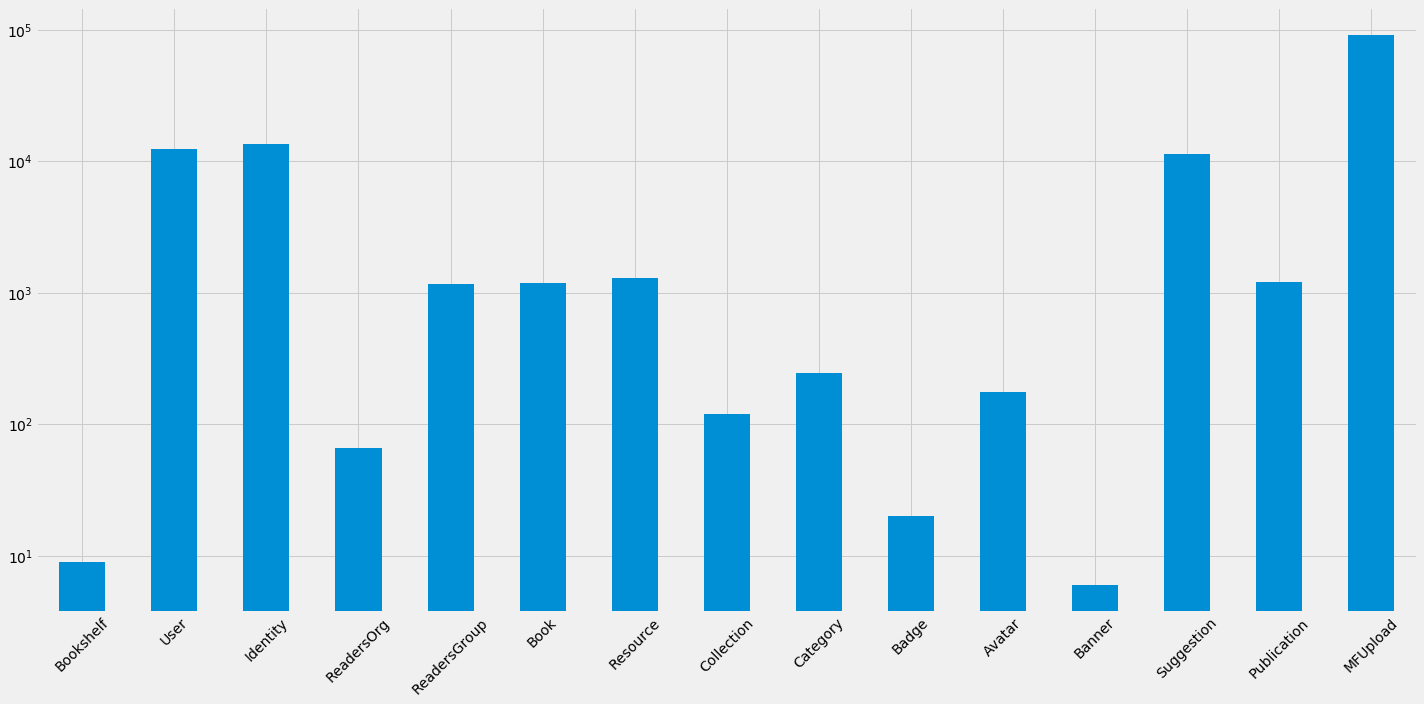

In [10]:
rcParams['figure.figsize'] = [20, 10]
nodes = get_number_of_nodes()
rels = get_number_of_relations()


result = {"label": [], "count": []}
with driver.session() as session:
    labels = [row["label"] for row in session.run("CALL db.labels()")]
    for label in labels:
        query = f"MATCH (:`{label}`) RETURN count(*) as count"
        count = session.run(query).single()["count"]
        result["label"].append(label)
        result["count"].append(count)
session.close()

df = pd.DataFrame(data=result)
print(tabulate(df.sort_values("count"), headers='keys',
                              tablefmt='psql', showindex=False))
style.use('fivethirtyeight')
ax = df.plot(kind='bar', x='label', y='count', legend=None)
ax.xaxis.set_label_text("")
yscale("log")
xticks(rotation=45)
tight_layout()
show()

### and all type of relationships between them

+---------------------+---------+
| relType             |   count |
|---------------------+---------|
| ADVERTISEMENT       |       6 |
| TAXONOMY            |      14 |
| OFFERS_REWARD       |      20 |
| CUSTOM_AVATAR       |      58 |
| PREDEFINED_AVATAR   |      83 |
| MANAGES             |     119 |
| INCLUDES            |     233 |
| PUBLISHED           |    1185 |
| DISTRIBUTED_THROUGH |    1187 |
| CONTAINS            |    6701 |
| SUGGESTED_TO        |    9997 |
| SUGGESTED_BY        |   10249 |
| SUGGESTED_RES       |   10942 |
| REGISTERED_IN       |   12374 |
| MEMBER_OF           |   28049 |
| PURCHASED           |   49341 |
| UPLOADED_BY         |   78792 |
| UPLOADED_FOR        |   91296 |
| READS               |  186609 |
+---------------------+---------+


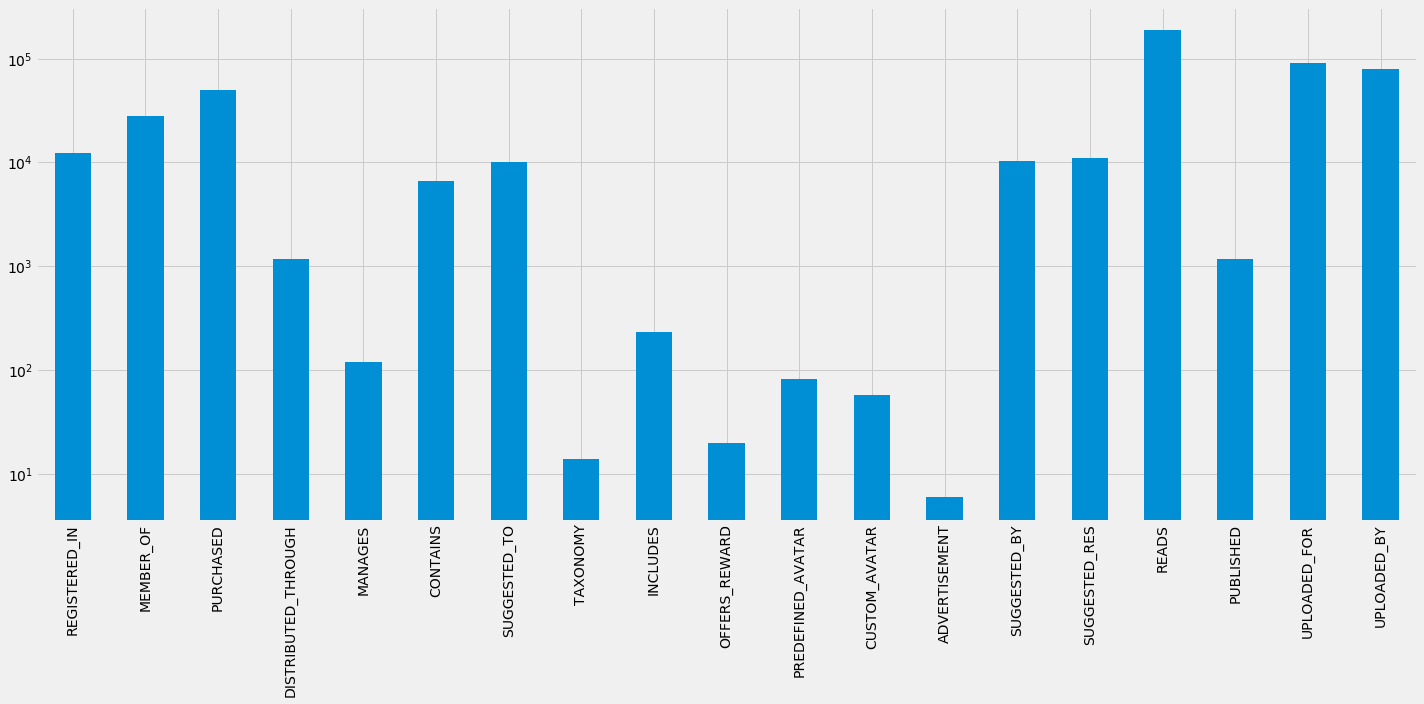

In [11]:
result = {"relType": [], "count": []}
with driver.session() as session:
    rel_types = [row["relationshipType"] for row in session.run("CALL db.relationshipTypes()")]
    for rel_type in rel_types:
        query_ = f"MATCH ()-[:`{rel_type}`]->() RETURN count(*) as count"
        count = session.run(query_).single()["count"]
        result["relType"].append(rel_type)
        result["count"].append(count)
session.close()        

df = pd.DataFrame(data=result)
print(tabulate(df.sort_values("count"), headers='keys',
                              tablefmt='psql', showindex=False))

ax = df.plot(kind='bar', x='relType', y='count', legend=None)
ax.xaxis.set_label_text("")
yscale("log")
xticks(rotation=90)
tight_layout()
show()

In [12]:
query_ = f"MATCH ()-[r]-() RETURN TYPE(r) as type, COUNT(*) as count"
result = query_neo4j_db(query_)
df = pd.DataFrame(data=result, columns = ['group', 'count'])
df

,group,count
0,REGISTERED_IN,24748
1,DISTRIBUTED_THROUGH,2374
2,TAXONOMY,28
3,OFFERS_REWARD,40
4,PREDEFINED_AVATAR,166
5,ADVERTISEMENT,12
6,MEMBER_OF,56098
7,SUGGESTED_BY,20498
8,READS,373218
9,UPLOADED_BY,157584


### Observing the data to goal our purpose, we obtain features which relate to student and reading process
### For that we use Cypher - the graph query language for Neo4j

In [107]:
# filter id - kutubee shell

In [174]:
query_ = """MATCH (ro:ReadersOrg)<-[m:MEMBER_OF]-(u:User)
WHERE m.role = 'student' or m.role = 'student '
MATCH (u)-[:READS]->(b:Book)--(c:Category) 
OPTIONAL MATCH (u)-[:MEMBER_OF]->(cl:ReadersGroup)-[:MEMBER_OF]->(ro)
RETURN  coalesce(cl.name) as group, ro.name as school, 
coalesce(cl.id) as group_id, ro.id as school_id, count(*) as count"""
result = query_neo4j_db(query_)
df_group = pd.DataFrame(data=result, columns = ['group', 'school','group_id', 'school_id', 'count'])

In [176]:
df_group.to_csv('E:\\User\\jupyter\\groups_id.csv', index=False)

In [ ]:
df_grades = pd.read_csv('E:\\User\\jupyter\\grades.csv')

In [175]:
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 5 columns):
group        511 non-null object
school       528 non-null object
group_id     511 non-null object
school_id    528 non-null object
count        528 non-null int64
dtypes: int64(1), object(4)
memory usage: 20.8+ KB


In [187]:
query_ = """MATCH (:Bookshelf {id: '9lj2wk14agj20j6ipb'})<-[:REGISTERED_IN]-(ro:ReadersOrg)<-[m:MEMBER_OF]-(u:User)
WHERE m.role = 'student' or m.role = 'student '
MATCH (u)-[:READS]->(b:Book)--(c:Category) 
OPTIONAL MATCH (u)-[:MEMBER_OF]->(cl:ReadersGroup)-[:MEMBER_OF]->(ro)
OPTIONAL MATCH (s:Suggestion)-[:SUGGESTED_RES]->(b)
WHERE (s)-[:SUGGESTED_TO]->(u) or (s)-[:SUGGESTED_TO]->(:ReadersGroup)<-[:MEMBER_OF]-(u)
RETURN  u.id as user, u.gender as gender, u.languages as slang,
s.startDate as start, s.expiresDate as expires, 
b.id as book, b.totalPages as pages, b.publisher, b.author, collect(c.id) as category, b.languages as blang,
coalesce(cl.name) as group, ro.name as school, coalesce(cl.id) as group_id, ro.id as school_id,
CASE WHEN s is NULL THEN 1 ELSE 0 END as byself"""
result = query_neo4j_db(query_)
df = pd.DataFrame(data=result, columns = ['user','gender', 'slang','start','expires','book', 'pages',
                                          'publisher', 'author', 'category', 'blang','group', 'school',
                                          'group_id', 'school_id','byself'])

In [188]:
df.describe(include='all')

,user,gender,slang,start,expires,book,pages,publisher,author,category,blang,group,school,group_id,school_id,byself
count,172911,172911,172911,3.149600e+04,3.149600e+04,172911,172911.000000,172911,172911,172911,172911,170247,172911,170247,172911,172911.000000
unique,6196,7,5,NaN,NaN,1143,NaN,23,374,807,2,411,50,511,50,NaN
top,405oplxjsn009t6,male,AR,NaN,NaN,9lj2wk5qqj6ep0qos,NaN,أصالة للنشر والتوزيع,صفاء عزمي,"[9lj2wk5qqj6eqk249, 9lj2wk5qqj6eql6q5, 9lj2wk5...",[AR],3A,Baptist School Lebanon,405opeyjcpybwzx,9lj2wkaogj9pdhac6,NaN
freq,1142,89210,163224,NaN,NaN,901,NaN,27396,20442,3222,133742,3730,21331,2393,21331,NaN
mean,NaN,NaN,NaN,1.544046e+12,1.546594e+12,NaN,21.672103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.817848
std,NaN,NaN,NaN,1.124979e+10,1.220390e+10,NaN,16.431827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.385970
min,NaN,NaN,NaN,1.506192e+12,1.507614e+12,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,1.540548e+12,1.541871e+12,NaN,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,1.545421e+12,1.548331e+12,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,1.551871e+12,1.554459e+12,NaN,26.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [189]:
df.head(10)

,user,gender,slang,start,expires,book,pages,publisher,author,category,blang,group,school,group_id,school_id,byself
0,cy8x6i12y2j9fsawng,female,AR,NaN,NaN,9lj2wk4lvj7tdb8ty,22,السلوى للدراسات والنشر,تغريد عارف النجار,"[9lj2wk5qqj6eqgy5a, 9lj2wk5qqj6eql6pm, 9lj2wk5...",[AR],الأول الاساسي ا,National Orthodox School,cy8x6i12nsj9fr1un9,cy8x6i12p5j9fr97q3,1
1,cy8x6i12y2j9fsawng,female,AR,NaN,NaN,9lj2wk5qqj6ep0qpl,22,السلوى للدراسات والنشر,تغريد عارف النجار,"[9lj2wk5qqj6eqgy5a, 9lj2wk5qqj6eql6pn, 9lj2wk5...",[AR],الأول الاساسي ا,National Orthodox School,cy8x6i12nsj9fr1un9,cy8x6i12p5j9fr97q3,1
2,cy8x6i12y2j9fsawng,female,AR,NaN,NaN,9lj2wk5qqj6ep0qos,37,السلوى للدراسات والنشر,تغريد عارف النجار,"[9lj2wk5qqj6eqgy5a, 9lj2wk5qqj6eql6pm, 9lj2wk5...",[AR],الأول الاساسي ا,National Orthodox School,cy8x6i12nsj9fr1un9,cy8x6i12p5j9fr97q3,1
3,cy8x6i12y2j9fsawng,female,AR,NaN,NaN,9lj2wk5qqj6ep0qrk,29,السلوى للدراسات والنشر,تغريد عارف النجار,"[9lj2wk5qqj6eqgy5a, 9lj2wk5qqj6eql6pr, 9lj2wk5...",[AR],الأول الاساسي ا,National Orthodox School,cy8x6i12nsj9fr1un9,cy8x6i12p5j9fr97q3,1
4,cy8x6i12y2j9fsawng,female,AR,NaN,NaN,9lj2wk71gjbcgkcj5,26,جبل عمان ناشرون,اليزابيت فيرديك,"[9lj2wk5qqj6eqgy5b, 9lj2wk5qqj6eql6pm, 9lj2wk5...",[AR],الأول الاساسي ا,National Orthodox School,cy8x6i12nsj9fr1un9,cy8x6i12p5j9fr97q3,1
5,cy8x6i12y2j9fsawng,female,AR,NaN,NaN,9lj2wk4lvj7tdb91l,25,السلوى للدراسات والنشر,تغريد عارف النجار,"[9lj2wk5qqj6eqgy5b, 9lj2wk5qqj6eql6po, 9lj2wk5...",[AR],الأول الاساسي ا,National Orthodox School,cy8x6i12nsj9fr1un9,cy8x6i12p5j9fr97q3,1
6,cy8x6i12y2j9fsawng,female,AR,NaN,NaN,9lj2wk4lvj7tdb8v7,14,دار الحدائق,عبير مزهر,"[9lj2wk5qqj6eqgy5b, 9lj2wk5qqj6eql6pi, 9lj2wk5...",[AR],الأول الاساسي ا,National Orthodox School,cy8x6i12nsj9fr1un9,cy8x6i12p5j9fr97q3,1
7,cy8x6i12y2j9fsawng,female,AR,NaN,NaN,9lj2wk5qqj6ep0qra,33,السلوى للدراسات والنشر,ميثاء الخياط,"[9lj2wk5qqj6eqgy5b, 9lj2wk5qqj6eql6pr, 9lj2wk5...",[AR],الأول الاساسي ا,National Orthodox School,cy8x6i12nsj9fr1un9,cy8x6i12p5j9fr97q3,1
8,cy8x6i12y2j9fsawng,female,AR,NaN,NaN,9lj2wk5qqj6ep0qqx,22,السلوى للدراسات والنشر,تغريد عارف النجار,"[9lj2wk5qqj6eqk248, 9lj2wk5qqj6eql6qb, 9lj2wk5...",[AR],الأول الاساسي ا,National Orthodox School,cy8x6i12nsj9fr1un9,cy8x6i12p5j9fr97q3,1
9,cy8x6i12y2j9fsawng,female,AR,NaN,NaN,9lj2wk5qqj6ep0qmc,22,السلوى للدراسات والنشر,تغريد عارف النجار,"[9lj2wk5qqj6eqk248, 9lj2wk5qqj6eql6pq, 9lj2wk5...",[AR],الأول الاساسي ا,National Orthodox School,cy8x6i12nsj9fr1un9,cy8x6i12p5j9fr97q3,1


In [82]:
#to reduce time of getting data for analasing we save our data to csv-file
df.to_csv('E:\\User\\jupyter\\sug_book.csv', index=False)

In [8]:
#In next time we could get our data faster
df = pd.read_csv('E:\\User\\jupyter\\sug_book.csv')

### Some users are being a member of a school but don't have relation to the specific class. These students are on a custom basis 

![title](img/3.png)

In [222]:
df[df['group'].isnull()].user.count() # school 

2664

In [223]:
df.loc[df['group'].isnull(),'group'] = 'undefined'

In [ ]:
![title](img/2.png)

### There are demonstrating how relational look in graph DB for one user
### We can notice that some book is suggesting to the group, some to the user directly. Many of books user read without any suggestion

![title](img/1.png)

### In this part, we are going to check features: null values, different writing of the same meaning (as we see above, gender has five meaning), converting datestamps to readable value and сetera

In [224]:
convDate = lambda x: datetime.fromtimestamp(int(x)/1000) if not pd.isnull(x) else x

df['start'] = df['start'].apply(convDate)
df['expires'] = df['expires'].apply(convDate)

### Not all rows include started and expires dates cause when student choose a book by self to read  it means there is not some deadline 

In [225]:
df.groupby(['group']).group.count().sort_values(ascending=False)


group
3A                                      3730
3D                                      3219
3B                                      3041
Second Grade A                          2947
2D                                      2727
                                        ... 
SANCAKTEPE 7-C                             1
PT                                         1
8 Boys AraB                                1
GUNESLI 9-B                                1
 СШ 148 ім. Івана Багряного м. Києва       1
Name: group, Length: 412, dtype: int64

In [226]:
df[df.user.isnull()].user.count()

0

In [227]:
df[df.book.isnull()].book.count()

0

In [228]:
df.groupby(['gender']).gender.count()

gender
femal        307
female     80253
female      1647
m              8
male       89210
male        1459
Name: gender, dtype: int64

In [229]:
df.loc[df.gender == 'femal', 'gender'] = 'female'
df.loc[df.gender == 'female ', 'gender'] = 'female'
df.loc[df.gender == 'male ', 'gender'] = 'male'
df.loc[df.gender == '', 'gender'] = 'undefined'
df.loc[df.gender == 'femailemale', 'gender'] = 'female'
df.loc[df.gender == 'm', 'gender'] = 'male'

In [230]:
df['gender'].fillna('undefined', inplace=True)
df['author'].fillna('undefined', inplace=True)

In [231]:
df.groupby(['gender']).gender.count()

gender
female       82207
male         90677
undefined       27
Name: gender, dtype: int64

In [232]:
df.groupby(['slang']).slang.count()

slang
AR    163224
Ar       139
EN      9064
ar       292
en       192
Name: slang, dtype: int64

In [233]:
df.loc[df.slang == 'Ar', 'slang'] = 'AR'
df.loc[df.slang == 'ar', 'slang'] = 'AR'
df.loc[df.slang == 'en', 'slang'] = 'EN'

In [234]:
df.groupby(['slang']).slang.count()

slang
AR    163655
EN      9256
Name: slang, dtype: int64

In [235]:
df.groupby(['publisher']).publisher.count()

publisher
Andersen Press                           4051
Collins                                 25517
Era Publications                        12012
Highlights for Children                  7115
Highlights for Chlidren                  1111
Karen Asfour                              419
Kutubee                                  3936
World Book, Inc.                        11927
أصالة للنشر والتوزيع                    27396
أوفير للطباعة والنشر                     2128
السلوى للدراسات والنشر                  12498
جبل عمان ناشرون                         12474
دار البراق لثقافة الطفل                   789
دار الحدائق                              9709
دار العالم العربي للنشر والتوزيع         3069
دار ربيع للنشر                           2879
دار نهضة مصر للنشر                       2318
سما للنشر والإنتاج والتوزيع              3874
قنديل للطباعة والنشر والتوزيع             439
كارن عصفور                               1005
كتب نون : مؤسسة ناهد الشوا الثقافية      6827
واحة الحكايات للنشر والت

In [236]:
df.groupby(['author']).author.count()

author
Adrian Bradbury        76
Alan Durant           128
Alison Hawes          241
Alison Sage            30
Amanda Graham        1206
                     ... 
هيلين تشابمان          63
وفاء توفيق القسوس    1070
يزن مصاروة             99
يعقوب الشاروني        207
یزن مصاروة            138
Name: author, Length: 374, dtype: int64

In [237]:
df.groupby(['byself']).byself.count()

byself
0     31496
1    141415
Name: byself, dtype: int64

In [238]:
df.blang.astype(str).unique()

array(["['AR']", "['EN']"], dtype=object)

In [239]:
df.blang = df.blang.astype(str)

In [240]:
rows = df[df.blang == "['UA']"]
labels = rows.index
df.loc[labels,'blang'] = 'UA'

In [241]:
rows = df[df.blang == "['RU']"]
labels = rows.index
df.loc[labels,'blang'] = 'RU'
rows = df[df.blang == "['DE']"]
labels = rows.index
df.loc[labels,'blang'] = 'DE'

In [242]:
rows = df[df.blang == "['EN']"]
labels = rows.index
df.loc[labels,'blang'] = 'EN'

In [243]:
rows = df[df.blang == "['AR']"]
labels = rows.index
df.loc[labels,'blang'] = 'AR'

In [244]:
df.blang.unique()

array(['AR', 'EN'], dtype=object)

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172911 entries, 0 to 172910
Data columns (total 16 columns):
user         172911 non-null object
gender       172911 non-null object
slang        172911 non-null object
start        31496 non-null datetime64[ns]
expires      31496 non-null datetime64[ns]
book         172911 non-null object
pages        172911 non-null int64
publisher    172911 non-null object
author       172911 non-null object
category     172911 non-null object
blang        172911 non-null object
group        172911 non-null object
school       172911 non-null object
group_id     170247 non-null object
school_id    172911 non-null object
byself       172911 non-null int64
dtypes: datetime64[ns](2), int64(2), object(12)
memory usage: 21.1+ MB


In [246]:
df.category = df.category.astype(str)

In [267]:
df['category'] = df.apply(lambda x: ast.literal_eval(x['category']), axis=1) 

In [268]:
cat = np.concatenate(df['category'].values)

In [270]:
cat = set(cat)

In [271]:
cat = list(cat)

In [272]:
len(cat)

175

In [273]:
def get_col(row, ncol):
    if ncol in row:
        v = 1
    else:
        v = 0
    return v

for ncol in cat:
    type(ncol)
    #df = df.assign(col=lambda x: 1 if col in x.category else 0)
    #df[col] = [lambda x: 1 if col in df['category'] else 0]
    df[ncol] = df['category'].apply(get_col, ncol=ncol)

In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172911 entries, 0 to 172910
Columns: 191 entries, user to 9lj2wk5qqj6equnms
dtypes: int64(177), object(14)
memory usage: 252.0+ MB


In [ ]:
#to reduce time of getting data for analasing we save our data to csv-file
df.to_csv('E:\\User\\jupyter\\sug_book_change.csv', index=False)

In [46]:
df.describe()

,pages,byself,9lj2wk5qqj6eql6qd,9lj2wk1vgjdhp8syb,9lj2wk5qqj6equnls,9lj2wk5qqj6eql6pu,9lj2wk5qqj6eql6qj,9lj2wk5qqj6equnm9,0208ejqj2bgu6,9lj2wk5qqj6equnmn,...,cy8x6ir8kjguch1gr,9lj2wk5qqj6eql6q8,9lj2wk5qqj6equnlz,9lj2wk5qqj6eql6q1,9lj2wk1vgjdhp8syd,9lj2wk5qqj6eql6qq,9lj2wk4k6j7tc9rre,cy8x6iiq7jk75qjh4,cy8x6ir8kjguch1gk,9lj2wk5qqj6equnms
count,172911.000000,172911.000000,172911.000000,172911.000000,172911.000000,172911.000000,172911.000000,172911.000000,172911.000000,172911.000000,...,172911.000000,172911.000000,172911.000000,172911.000000,172911.000000,172911.000000,172911.000000,172911.000000,172911.000000,172911.000000
mean,21.672103,0.817848,0.057689,0.017749,0.019039,0.009780,0.017529,0.006957,0.022763,0.017639,...,0.003701,0.037435,0.111121,0.079399,0.022405,0.403346,0.007183,0.003563,0.003129,0.043872
std,16.431827,0.385970,0.233154,0.132038,0.136661,0.098407,0.131233,0.083120,0.149148,0.131636,...,0.060726,0.189827,0.314283,0.270362,0.147996,0.490571,0.084447,0.059581,0.055848,0.204811
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,26.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,282.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df = pd.read_csv('E:\\User\\jupyter\\sug_book_change.csv',low_memory=False)

### Getting data from MongoDB shell

![title](img/2.png)

In [10]:
client = MongoClient('localhost', 27017)

In [35]:
from pprintpp import pprint as pp
db = client.commands
pp(client.admin.command({"listDatabases" : 1}))

{
    'databases': [
        {'empty': False, 'name': 'admin', 'sizeOnDisk': 180224.0},
        {'empty': False, 'name': 'analytics', 'sizeOnDisk': 691638272.0},
        {'empty': False, 'name': 'assets', 'sizeOnDisk': 10104832.0},
        {'empty': False, 'name': 'auth', 'sizeOnDisk': 3448832.0},
        {'empty': False, 'name': 'config', 'sizeOnDisk': 118784.0},
        {'empty': False, 'name': 'identity', 'sizeOnDisk': 110592.0},
        {'empty': False, 'name': 'local', 'sizeOnDisk': 294912.0},
        {'empty': False, 'name': 'permissions', 'sizeOnDisk': 45056.0},
        {'empty': False, 'name': 'pubdata', 'sizeOnDisk': 86519808.0},
        {'empty': False, 'name': 'publications', 'sizeOnDisk': 19922944.0},
        {'empty': False, 'name': 'test', 'sizeOnDisk': 20480.0},
        {'empty': False, 'name': 'transactions', 'sizeOnDisk': 73728.0},
    ],
    'ok': 1.0,
    'totalSize': 812478464.0,
}


### Analyzing databases, we concluded that we require database Analytics.Events, where are recorded all transactions of students, when they open books

In [11]:
#events = client.get_database('analytics').get_collection('events')
database = client["analytics"]
collection = database["events"]

In [54]:
query = {}
query["application"] = u"bookshelf"

cursor = collection.find(query)

In [ ]:
count_ = cursor.count() #5165012

In [14]:
chunk_size = int(count_/100)

### Chunking database to avoiding dump memory

In [ ]:
# Some variables to create the chunks
index_ = range(0, count_, chunk_size)

# Iteration to create the dataframe in chunks.
for i in range(1,len(index_)):

    # Expand the cursor and construct the DataFrame
    df_events = pd.DataFrame(list(collection.find(query)[index_[i-1]:index_[i]]))

    # Concatenate the chunks into a unique df_mongo
    if 'df_mongo' not in locals():
        df_mongo = df_events
    else:
        df_mongo = pd.concat([df_mongo, df_events], ignore_index=True)


In [42]:
df_mongo.to_csv('E:\\User\\jupyter\\events.csv',index=False)

In [5]:
df_mongo = pd.read_csv('E:\\User\\jupyter\\events.csv')
df_mongo.drop(['Unnamed: 0'],axis=1,inplace=True)

In [75]:
df_mongo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165000 entries, 0 to 5164999
Data columns (total 9 columns):
_id            object
session        object
type           object
userId         object
application    object
timestamp      float64
data           object
serverDate     object
__v            int64
dtypes: float64(1), int64(1), object(7)
memory usage: 354.7+ MB


In [76]:
df_mongo.head()

,_id,session,type,userId,application,timestamp,data,serverDate,__v
0,5a0d7223dfd8af0038c15936,5a0d7223dfd8af0038c15937,book-open,405opoxj81gy6x5,bookshelf,1.510831e+12,{'deviceId': '396cbdf615eccf0ed3caeb24ad368041...,2017-11-16 11:10:27.902,0
1,5a0d7223dfd8af0038c15938,5a0d7223dfd8af0038c15937,page-open,405opoxj81gy6x5,bookshelf,1.510831e+12,{'deviceId': '396cbdf615eccf0ed3caeb24ad368041...,2017-11-16 11:10:27.987,0
2,5a0d7223dfd8af0038c15939,5a0d7223dfd8af0038c15937,page-open,405opoxj81gy6x5,bookshelf,1.510831e+12,{'deviceId': '396cbdf615eccf0ed3caeb24ad368041...,2017-11-16 11:10:27.992,0
3,5a0d7223dfd8af0038c1593a,5a0d7223dfd8af0038c15937,page-open,405opoxj81gy6x5,bookshelf,1.510831e+12,{'deviceId': '396cbdf615eccf0ed3caeb24ad368041...,2017-11-16 11:10:27.994,0
4,5a0d7223dfd8af0038c1593b,5a0d7223dfd8af0038c15937,book-close,405opoxj81gy6x5,bookshelf,1.510831e+12,{'deviceId': '396cbdf615eccf0ed3caeb24ad368041...,2017-11-16 11:10:27.995,0


### We require  actions with bookshelf

In [77]:
df_mongo.groupby(['application']).application.count()

application
bookshelf    5165000
Name: application, dtype: int64

In [6]:
df_mongo['timestamp'] = df_mongo['timestamp'].apply(convDate)

In [7]:
df_mongo.drop(['_id','application','__v'], axis=1, inplace=True)

### Assign new columns to a DataFrame from Data column witch includes information about book and page.

In [80]:
df_mongo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165000 entries, 0 to 5164999
Data columns (total 6 columns):
session       object
type          object
userId        object
timestamp     datetime64[ns]
data          object
serverDate    object
dtypes: datetime64[ns](1), object(5)
memory usage: 236.4+ MB


In [8]:
df_mongo['data'] = df_mongo.apply(lambda x: ast.literal_eval(x['data']), axis=1) # to readable dict format

### Extracting information about book and page which are into subdocument Data and assign new columns to the DataFrame 
### Using chunk cause a significant amount of database rows 

In [9]:
def get_value(x, field):
    if x is None: return ''
    keys = x.keys()
    if field in keys:
        result = x[field]
    else: result = ''    
    return result

count_ = int(df_mongo.session.count())
chunk_size = int(count_/10)
# Some variables to create the chunks
index_ = range(0, count_, chunk_size)

n = len(index_) + 1;

df_mongo.loc[:,('bookId')] = ""
df_mongo.loc[:,('pageId')] = 0
df_mongo.loc[:,('viewMode')] = 0

# Iteration to create the dataframe in chunks.
for i in range(1, n):
    if i != n:
        df_mongo.loc[index_[i-1]:index_[i],'bookId'] = df_mongo.loc[index_[i-1]:index_[i],'data']\
                                                .apply(get_value, field='bookId')   
        df_mongo.loc[index_[i-1]:index_[i],'pageId'] = df_mongo.loc[index_[i-1]:index_[i],'data']\
                                                .apply(get_value, field='pageId')
        df_mongo.loc[index_[i-1]:index_[i],'viewMode'] = df_mongo.loc[index_[i-1]:index_[i],'data']\
                                                .apply(get_value, field='viewMode')
        
    else:
        df_mongo.loc[index_[i-1]:,'bookId'] = df_mongo.loc[index_[i-1]:,'data']\
                                                .apply(get_value, field='bookId')   
        df_mongo.loc[index_[i-1]:,'pageId'] = df_mongo.loc[index_[i-1]:,'data']\
                                                .apply(get_value, field='pageId')
        df_mongo.loc[index_[i-1]:,'viewMode'] = df_mongo.loc[index_[i-1]:,'data']\
                                                .apply(get_value, field='viewMode')
df_mongo.drop(['data'], axis=1, inplace=True)

In [233]:
#df_mongo = pd.read_csv('E:\\User\\jupyter\\events.csv',dtype={'type':'str','pageId':'int'},parse_dates=['timestamp'],low_memory=False)

### Now we want to calculate the score of reading a particular book.
### It can notice that the student might reread of book. 

In [290]:
df[(df.user=='9lj2wk47rj7sxc50o')&(df.book=='9lj2wk5qqj6ep0qql')]

,user,gender,readl,lang,start,expires,book,pages,publisher,author,group,byself
22717,9lj2wk47rj7sxc50o,male,0.0,AR,NaN,NaN,9lj2wk5qqj6ep0qql,25,دار ربيع للنشر,NaN,Second Grade B,1


In [292]:
df_mongo[(df_mongo.userId=='9lj2wk47rj7sxc50o')
                        &(df_mongo.bookId=='9lj2wk5qqj6ep0qql')].groupby('pageId').pageId.count()

pageId
0      1
1      3
2      5
3      6
4      8
5     11
6      9
7      4
8      2
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     1
21     1
22     2
23     2
24     1
       8
Name: pageId, dtype: int64

In [42]:
df_mongo.pageId = pd.to_numeric(df_mongo.pageId)

In [44]:
rows = df_mongo[df_mongo.pageId.isnull()]
labels = rows.index
df_mongo.loc[labels,'pageId'] = 0

### Repeat row for view-mode 2 - two pages in one view

In [28]:
book = df.groupby('book').pages.max()

In [29]:
book

book
9lj2wk4lvj7tdb8ng     6
9lj2wk4lvj7tdb8nl     7
9lj2wk4lvj7tdb8nm     7
9lj2wk4lvj7tdb8nn     7
9lj2wk4lvj7tdb8no     6
                     ..
cy8x6iyq7jhk75pr0    25
cy8x6iyq7jhk75pr1    41
cy8x6iyq7jhk75pr2    37
cy8x6iyq7jhk75pr3    29
cy8x6izsejgewkhz4    18
Name: pages, Length: 1161, dtype: int64

In [62]:
df_mongo = df_mongo.set_index('bookId')

In [67]:
df_mongo = df_mongo.merge(book, how='left', left_index=True, right_index=True)

In [71]:
df_mongo.reset_index(inplace=True)

In [111]:
rows = df_mongo[(df_mongo.viewMode==2)&(df_mongo.pageId<=df_mongo.pages)&(df_mongo.pageId!=0)]

In [ ]:
rows.reset_index(inplace=True)
rows.drop('level_0', axis=1, inplace=True)

In [ ]:
rows['pageId'] = rows['pageId'].apply(lambda x: x-1)

In [116]:
df_mongo = df_mongo.append(rows, ignore_index=True)

In [15]:
df_mongo.loc[df_mongo.bookId.isnull()]

,session,type,userId,timestamp,serverDate,bookId,pageId,viewMode


In [120]:
df_mongo.rename(columns={"index": "bookId"}, inplace=True)

In [121]:
df_temp = df_mongo.drop_duplicates(subset=['session','bookId'])

In [122]:
df_temp = df_temp.groupby(by=['session','bookId'], as_index=False).first()

In [123]:
session = df_temp.session.unique()

In [124]:
session.shape

(79656,)

### sometimes the page with higher number  appears before lower one cause it appropriate to sort by timestamp to obtain a right score of reading

In [125]:
df_mongo.sort_values(by=['session','bookId','timestamp'],inplace=True)

In [126]:
df_mongo['score'] = 0.0

### receiving each score of each reading page by calculating differences between data time of rows
### to avoid dump of memory doing iterations

In [ ]:
df_mongo.set_index(keys=['session','bookId'], inplace=True)

for s in session:
    books = df_temp[df_temp.session == s].bookId.to_list()
    for b in books:
        df_mongo.loc[(s,b),'score'] = df_mongo.loc[(s,b),'timestamp'].diff().dt.total_seconds().values
        
df_mongo.reset_index(inplace=True)  

In [128]:
df_mongo.to_csv('E:\\User\\jupyter\\events_score.csv', index=False)

In [4]:
df_mongo =  pd.read_csv('E:\\User\\jupyter\\events_score.csv',dtype={'type':'str','pageId':'int'},parse_dates=['timestamp'],low_memory=False)

### the page could open many times and not easy to recognize where the real reading result

### leaving rows with 'page-open' information

In [129]:
df_mongo.describe()

,pageId,pages,score
count,5.498702e+06,5.487581e+06,5.323135e+06
mean,9.680480e+00,2.489986e+01,9.746326e+01
std,1.111540e+01,1.987076e+01,7.304121e+03
min,0.000000e+00,2.000000e+00,0.000000e+00
25%,3.000000e+00,1.600000e+01,3.200000e-02
50%,7.000000e+00,2.100000e+01,9.740000e-01
75%,1.400000e+01,2.900000e+01,6.410000e+00
max,2.810000e+02,2.820000e+02,6.646295e+06


In [64]:
df_mongo[(df_mongo.session=='5b9a239453364a0037dabb77')&(df_mongo.bookId=='cy8x6iiq7jk75qj9q')&(df_mongo.pageId==4)]

,session,bookId,type,userId,timestamp,serverDate,pageId,score
1000979,5b9a239453364a0037dabb77,cy8x6iiq7jk75qj9q,page-open,9lj2wkaozj9pdwqqe,2018-09-13 11:42:02.840,2018-09-13 08:45:08.525,4.0,3.851
1001009,5b9a239453364a0037dabb77,cy8x6iiq7jk75qj9q,page-open,9lj2wkaozj9pdwqqe,2018-09-13 11:45:10.585,2018-09-13 08:50:23.535,4.0,0.280
1001011,5b9a239453364a0037dabb77,cy8x6iiq7jk75qj9q,page-open,9lj2wkaozj9pdwqqe,2018-09-13 11:45:11.047,2018-09-13 08:50:23.538,4.0,0.258
1001013,5b9a239453364a0037dabb77,cy8x6iiq7jk75qj9q,page-open,9lj2wkaozj9pdwqqe,2018-09-13 11:45:11.542,2018-09-13 08:50:23.541,4.0,0.225
1001019,5b9a239453364a0037dabb77,cy8x6iiq7jk75qj9q,page-open,9lj2wkaozj9pdwqqe,2018-09-13 11:45:30.593,2018-09-13 08:50:23.552,4.0,1.081
1001021,5b9a239453364a0037dabb77,cy8x6iiq7jk75qj9q,page-open,9lj2wkaozj9pdwqqe,2018-09-13 11:45:43.955,2018-09-13 08:50:23.556,4.0,1.194
1001023,5b9a239453364a0037dabb77,cy8x6iiq7jk75qj9q,page-open,9lj2wkaozj9pdwqqe,2018-09-13 11:46:12.586,2018-09-13 08:50:23.560,4.0,0.767
1001069,5b9a239453364a0037dabb77,cy8x6iiq7jk75qj9q,page-open,9lj2wkaozj9pdwqqe,2018-09-13 12:39:23.661,2018-09-13 09:47:44.780,4.0,0.851
1001079,5b9a239453364a0037dabb77,cy8x6iiq7jk75qj9q,page-open,9lj2wkaozj9pdwqqe,2018-09-13 12:40:05.275,2018-09-13 09:47:44.798,4.0,0.508


In [167]:
df_mongo.loc[(df_mongo.score != 0)&(df_mongo.type!='page-open'),'score'] = 0

In [168]:
error_score_user = df_mongo[(df_mongo.score >= 3600)]['userId'].unique()

In [169]:
len(error_score_user)

1346

In [186]:
mean_ = df_mongo[df_mongo.userId.isin(error_score_user)&(df_mongo.score < 3600)].groupby('userId').score.mean()

In [187]:
mean_

userId
011u1jqofhi66      3.659779
011u1jqofhi6d      4.869605
011u1jqofhi8j     10.157552
016r1jpuzjff3     12.844209
016r1jpuzjff8     14.653449
                    ...    
eeyvczjtzj5r7t     4.053967
eeyvczjuc7jphm    12.309147
eeyvczjuc7sy2d     5.727319
eeyvczjucb2jh5     5.700338
eeyvczjup3j8v4     8.633374
Name: score, Length: 1346, dtype: float64

In [181]:
df_mongo.reset_index(inplace=True)

### There was some incorrect result when one page was reading more than 1 hour. we rewrite these rows to mean values for every user

In [183]:
rows = df_mongo[df_mongo.userId.isin(error_score_user)&(df_mongo.score >= 3600)] #2436 rows
labels = rows.index

In [196]:
for i in labels:
    userId = df_mongo.loc[i].userId
    df_mongo.loc[i, 'score'] = mean_[userId]

In [ ]:
df_mongo = df_mongo.set_index('date_d')

In [203]:
df_mongo.score.mean()

9.476369741790167

In [8]:
df_mongo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5498702 entries, 0 to 5498701
Data columns (total 10 columns):
session       object
bookId        object
type          object
userId        object
timestamp     datetime64[ns]
serverDate    object
pageId        int32
viewMode      float64
pages         float64
score         float64
dtypes: datetime64[ns](1), float64(3), int32(1), object(5)
memory usage: 398.5+ MB


In [7]:
#df_mongo.drop(['year','month','DayofWeek','date_d'],axis=1, inplace=True)

In [226]:
df_mongo.to_csv('E:\\User\\jupyter\\events_score1.csv', index=False)

In [290]:
df_mongo =  pd.read_csv('E:\\User\\jupyter\\events_score1.csv',dtype={'type':'str','pageId':'int'},parse_dates=['timestamp','date_d'],low_memory=False)

In [ ]:
#drop sessions without reading pages
#df_temp = df_mongo.groupby(['session'],as_index=False).pageId.sum()
#df_temp = df_temp[df_temp.pageId == 0].session.values
#rows = (df_mongo.loc[df_mongo.session.isin(df_temp)])
#labels = rows.index


### aggregating data to obtaine result

In [279]:
df_mongo['date_d'] = df_mongo['timestamp'].dt.to_period(freq="D") # to obtain first entering to app

In [280]:
df_mongo['viewMode'].fillna(0, inplace=True)

In [281]:
df_mongo.viewMode = df_mongo.viewMode.astype(int)

In [284]:
df_mongo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5498702 entries, 0 to 5498701
Data columns (total 9 columns):
date_d       period[D]
session      object
bookId       object
type         object
userId       object
timestamp    datetime64[ns]
pageId       int32
viewMode     int32
score        float64
dtypes: datetime64[ns](1), float64(1), int32(2), object(4), period[D](1)
memory usage: 335.6+ MB


In [294]:
df_mongo.score = round(df_mongo.score,2)

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172911 entries, 0 to 172910
Columns: 191 entries, user to 9lj2wk5qqj6equnms
dtypes: int64(177), object(14)
memory usage: 252.0+ MB


In [33]:
df_res_score = df_mongo[df_mongo.type == 'page-open'].groupby(['userId','bookId']).score.mean()

In [34]:
df_res = df_mongo.groupby(['userId','bookId']).agg({'pageId':['count','nunique','max'],
                                                    'date_d':['min'],'session':['nunique']})

In [24]:
df_res_score.describe()

count    121491.000000
mean          9.625828
std          15.007209
min           0.058239
25%           2.531600
50%           6.130154
75%          11.897003
max        1330.486500
Name: score, dtype: float64

In [35]:
df_res.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in df_res.columns]

In [36]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 122827 entries, (00000000-0000-0000-0000-000000000000, 013hejsygp863) to (ef16oyjvvgkmtb, 9lj2wk4lvj7tdb8pe)
Data columns (total 5 columns):
pageId_count       122827 non-null int64
pageId_nunique     122827 non-null int64
pageId_max         122827 non-null int32
date_d_min         122827 non-null datetime64[ns]
session_nunique    122827 non-null int64
dtypes: datetime64[ns](1), int32(1), int64(3)
memory usage: 4.8+ MB


In [37]:
df_res = pd.merge(df_res, df_res_score, how='left',left_on=('userId','bookId'),right_on=('userId','bookId'))

In [40]:
df_res.reset_index(inplace=True)

In [41]:
df_res.describe()

,pageId_count,pageId_nunique,pageId_max,session_nunique,score
count,122827.000000,122827.000000,122827.000000,122827.000000,121491.000000
mean,44.767698,15.982740,15.068202,1.429311,9.625828
std,59.061746,10.863919,10.895330,1.247618,15.007209
min,2.000000,1.000000,0.000000,1.000000,0.058239
25%,15.000000,9.000000,8.000000,1.000000,2.531600
50%,27.000000,16.000000,15.000000,1.000000,6.130154
75%,52.000000,20.000000,19.000000,2.000000,11.897003
max,2192.000000,282.000000,281.000000,212.000000,1330.486500


In [42]:
df_res.rename(columns={"score": "score_mean"}, inplace=True)

### Amount of full concurrence is 5552. there are still users with have relationships 'reads' but don't' have reading transactions, 5399

In [47]:
df_prep = pd.merge(df_res, df, how='outer',left_on=('userId','bookId'),right_on=('user','book'))

In [48]:
len(df_prep[df_prep.userId==df_prep.user].user.unique())

5552

In [49]:
len(df_prep[df_prep['userId'].isnull()].user.unique())

5399

In [50]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203764 entries, 0 to 203763
Columns: 199 entries, userId to 9lj2wk5qqj6equnms
dtypes: datetime64[ns](1), float64(182), object(16)
memory usage: 310.9+ MB


In [51]:
rows = (df_prep[df_prep['user'].isnull()])
labels = rows.index
df_prep.drop(labels, inplace=True)

In [52]:
rows = df_prep[(df_prep.school == 'CYTest')|(df_prep.school == 'Kutubee Demo School N1')]
labels = rows.index
df_prep.drop(labels, inplace=True)

In [53]:
df_prep.to_csv('E:\\User\\jupyter\\neo_merge.csv', index=False)

In [54]:
df_prep.drop(['userId','bookId'], axis=1, inplace=True)

In [55]:
df_prep.fillna(0, inplace=True)

In [56]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170988 entries, 19 to 203761
Columns: 197 entries, pageId_count to 9lj2wk5qqj6equnms
dtypes: float64(182), object(15)
memory usage: 258.3+ MB


In [57]:
df_prep.describe()

,pageId_count,pageId_nunique,pageId_max,session_nunique,score_mean,pages,byself,9lj2wk5qqj6eql6qd,9lj2wk1vgjdhp8syb,9lj2wk5qqj6equnls,...,cy8x6ir8kjguch1gr,9lj2wk5qqj6eql6q8,9lj2wk5qqj6equnlz,9lj2wk5qqj6eql6q1,9lj2wk1vgjdhp8syd,9lj2wk5qqj6eql6qq,9lj2wk4k6j7tc9rre,cy8x6iiq7jk75qjh4,cy8x6ir8kjguch1gk,9lj2wk5qqj6equnms
count,170988.000000,170988.000000,170988.000000,170988.000000,170988.000000,170988.000000,170988.000000,170988.000000,170988.000000,170988.000000,...,170988.000000,170988.000000,170988.000000,170988.000000,170988.000000,170988.000000,170988.000000,170988.000000,170988.000000,170988.000000
mean,25.552284,8.885179,8.384349,0.785997,5.460239,21.678018,0.816566,0.057946,0.017609,0.019007,...,0.003684,0.037435,0.110212,0.079579,0.022288,0.403356,0.007176,0.003550,0.003158,0.043629
std,49.905774,11.300522,11.003153,1.060877,12.386031,16.474359,0.387023,0.233641,0.131527,0.136550,...,0.060588,0.189827,0.313155,0.270641,0.147619,0.490572,0.084407,0.059476,0.056108,0.204268
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,3.000000,3.000000,1.000000,0.902873,18.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,16.000000,15.000000,1.000000,7.272900,26.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1758.000000,282.000000,281.000000,78.000000,1330.486500,282.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
df_prep[df_prep.score_mean!=0].describe()

,pageId_count,pageId_nunique,pageId_max,session_nunique,score_mean,pages,byself,9lj2wk5qqj6eql6qd,9lj2wk1vgjdhp8syb,9lj2wk5qqj6equnls,...,cy8x6ir8kjguch1gr,9lj2wk5qqj6eql6q8,9lj2wk5qqj6equnlz,9lj2wk5qqj6eql6q1,9lj2wk1vgjdhp8syd,9lj2wk5qqj6eql6qq,9lj2wk4k6j7tc9rre,cy8x6iiq7jk75qjh4,cy8x6ir8kjguch1gk,9lj2wk5qqj6equnms
count,93163.000000,93163.000000,93163.000000,93163.000000,93163.000000,93163.000000,93163.000000,93163.000000,93163.000000,93163.000000,...,93163.000000,93163.000000,93163.000000,93163.000000,93163.000000,93163.000000,93163.000000,93163.000000,93163.000000,93163.000000
mean,46.872621,16.297833,15.388330,1.432006,10.021525,21.656001,0.775844,0.053165,0.016605,0.020276,...,0.004777,0.039350,0.110924,0.075899,0.021919,0.384681,0.007900,0.003521,0.003628,0.042324
std,59.768929,10.660462,10.697041,1.065763,15.357732,17.077019,0.417027,0.224363,0.127788,0.140945,...,0.068948,0.194428,0.314040,0.264838,0.146419,0.486522,0.088531,0.059231,0.060124,0.201328
min,2.000000,1.000000,0.000000,1.000000,0.078000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,9.000000,8.000000,1.000000,2.934631,16.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,16.000000,15.000000,1.000000,6.579955,18.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,20.000000,20.000000,2.000000,12.317625,25.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1758.000000,282.000000,281.000000,78.000000,1330.486500,282.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
#df_prep = pd.read_csv('E:\\User\\jupyter\\neo_merge.csv',dtype={'pageId':'int','byself':'int'},parse_dates=['start','expires'],low_memory=False)

In [60]:
df_prep['read_intime'] = 0 # to time of suggetion of teacher
df_prep['pread'] = 0.0 ## % of book
df_prep['read_result']=0.0 ## count how many times reaing

In [61]:
df_prep['expires'] = pd.to_datetime(df_prep['expires'], errors='coerce')

In [65]:
users = df[df.byself == 0].user.unique()

In [66]:
users.shape

(3454,)

In [71]:
books = df[df.byself == 0].book.unique()

In [72]:
books.shape

(708,)

In [69]:
books = df_prep[df_prep.byself == 0].book.unique()

In [70]:
books.shape

(703,)

In [67]:
users = df_prep[df_prep.byself == 0].user.unique()

In [68]:
users.shape

(3449,)

In [75]:
mongoNeo.reset_index(inplace=True)

In [76]:
#to find last time read 
mongoNeo.set_index(keys=['userId','bookId'], inplace=True)

In [77]:
mongoNeo.sort_index(level=mongoNeo.index.names, inplace=True)

In [78]:
df_prep.reset_index(inplace=True)

In [79]:
df_prep.set_index(keys=['user','book'], inplace=True)
df_prep.sort_index(level=df_prep.index.names, inplace=True)

###  there we notice that a student read tail of the book

In [99]:
df_mongo.loc[('0ofhjqyukypn','cy8x6iu5ujl0k7jcq')]

index     date_d                   session  \
userId       bookId                                                            
0ofhjqyukypn cy8x6iu5ujl0k7jcq  4013638 2019-03-01  5c792c4d38436c0037a9d70a   
             cy8x6iu5ujl0k7jcq  4013639 2019-03-01  5c792c4d38436c0037a9d70a   
             cy8x6iu5ujl0k7jcq  4013640 2019-03-01  5c792c4d38436c0037a9d70a   
             cy8x6iu5ujl0k7jcq  4013641 2019-03-01  5c792c4d38436c0037a9d70a   
             cy8x6iu5ujl0k7jcq  4013642 2019-03-01  5c792c4d38436c0037a9d70a   
             cy8x6iu5ujl0k7jcq  4013643 2019-03-01  5c792c4d38436c0037a9d70a   
             cy8x6iu5ujl0k7jcq  4013644 2019-03-01  5c792c4d38436c0037a9d70a   
             cy8x6iu5ujl0k7jcq  4013645 2019-03-01  5c792c4d38436c0037a9d70a   
             cy8x6iu5ujl0k7jcq  4013646 2019-03-01  5c792c4d38436c0037a9d70a   
             cy8x6iu5ujl0k7jcq  4013647 2019-03-01  5c792c4d38436c0037a9d70a   

                                      type               timestamp  \
userId       bookId                                                  
0ofhjqyukypn cy8x6iu5ujl0k7jcq   book-open 2019-03-01 14:57:06.294   
             cy8x6iu5ujl0k7jcq   page-open 2019-03-01 14:57:09.629   
             cy8x6iu5ujl0k7jcq   page-open 2019-03-01 14:57:09.630   
             cy8x6iu5ujl0k7jcq   page-open 2019-03-01 14:57:10.528   
             cy8x6iu5ujl0k7jcq   page-open 2019-03-01 14:57:10.529   
             cy8x6iu5ujl0k7jcq   page-open 2019-03-01 14:57:11.035   
             cy8x6iu5ujl0k7jcq   page-open 2019-03-01 14:57:11.036   
             cy8x6iu5ujl0k7jcq   page-open 2019-03-01 14:57:11.771   
             cy8x6iu5ujl0k7jcq   page-open 2019-03-01 14:57:11.772   
             cy8x6iu5ujl0k7jcq  book-close 2019-03-01 14:57:47.345   

                                             serverDate  pageId  viewMode  \
userId       bookId                                                         
0ofhjqyukypn cy8x6iu5ujl0k7jcq  2019-03-01 12:57:49.082       0       NaN   
             cy8x6iu5ujl0k7jcq  2019-03-01 12:57:49.203      62       1.0   
             cy8x6iu5ujl0k7jcq  2019-03-01 12:57:49.241      63       1.0   
             cy8x6iu5ujl0k7jcq  2019-03-01 12:57:49.243      60       1.0   
             cy8x6iu5ujl0k7jcq  2019-03-01 12:57:49.261      61       1.0   
             cy8x6iu5ujl0k7jcq  2019-03-01 12:57:49.263      62       1.0   
             cy8x6iu5ujl0k7jcq  2019-03-01 12:57:49.323      63       1.0   
             cy8x6iu5ujl0k7jcq  2019-03-01 12:57:49.363      64       1.0   
             cy8x6iu5ujl0k7jcq  2019-03-01 12:57:49.424      65       1.0   
             cy8x6iu5ujl0k7jcq  2019-03-01 12:57:49.445       0       NaN   

                                pages  score  DayofWeek  month  year  
userId       bookId                                                   
0ofhjqyukypn cy8x6iu5ujl0k7jcq   66.0  0.000          4      3  2019  
             cy8x6iu5ujl0k7jcq   66.0  3.335          4      3  2019  
             cy8x6iu5ujl0k7jcq   66.0  0.001          4      3  2019  
             cy8x6iu5ujl0k7jcq   66.0  0.898          4      3  2019  
             cy8x6iu5ujl0k7jcq   66.0  0.001          4      3  2019  
             cy8x6iu5ujl0k7jcq   66.0  0.506          4      3  2019  
             cy8x6iu5ujl0k7jcq   66.0  0.001          4      3  2019  
             cy8x6iu5ujl0k7jcq   66.0  0.735          4      3  2019  
             cy8x6iu5ujl0k7jcq   66.0  0.001          4      3  2019  
             cy8x6iu5ujl0k7jcq   66.0  0.000          4      3  2019

### When some students reread pages, and we require return right finishing time of reading in the first time, we will return time of the first occurrence of the last page when the result of reading is 100 percent.

In [100]:
df_mongo.loc[('eeyvczjtzj5r7t','cy8x6iiq7jk75qjfe')]

index     date_d  \
userId         bookId                                  
eeyvczjtzj5r7t cy8x6iiq7jk75qjfe  4665740 2019-04-09   
               cy8x6iiq7jk75qjfe  4665741 2019-04-09   
               cy8x6iiq7jk75qjfe  4665742 2019-04-09   
               cy8x6iiq7jk75qjfe  4665743 2019-04-09   
               cy8x6iiq7jk75qjfe  4665744 2019-04-09   
               cy8x6iiq7jk75qjfe  4665745 2019-04-09   
               cy8x6iiq7jk75qjfe  4665746 2019-04-09   
               cy8x6iiq7jk75qjfe  4665747 2019-04-09   
               cy8x6iiq7jk75qjfe  4665748 2019-04-09   
               cy8x6iiq7jk75qjfe  4665749 2019-04-09   
               cy8x6iiq7jk75qjfe  4665750 2019-04-09   
               cy8x6iiq7jk75qjfe  4665751 2019-04-09   
               cy8x6iiq7jk75qjfe  4665752 2019-04-09   
               cy8x6iiq7jk75qjfe  4665753 2019-04-09   
               cy8x6iiq7jk75qjfe  4665754 2019-04-09   
               cy8x6iiq7jk75qjfe  4665755 2019-04-09   
               cy8x6iiq7jk75qjfe  4665756 2019-04-09   
               cy8x6iiq7jk75qjfe  4665757 2019-04-09   
               cy8x6iiq7jk75qjfe  4665758 2019-04-09   
               cy8x6iiq7jk75qjfe  4665759 2019-04-09   
               cy8x6iiq7jk75qjfe  4665760 2019-04-09   
               cy8x6iiq7jk75qjfe  4665761 2019-04-09   
               cy8x6iiq7jk75qjfe  4665762 2019-04-09   
               cy8x6iiq7jk75qjfe  4665763 2019-04-09   
               cy8x6iiq7jk75qjfe  4665764 2019-04-09   
               cy8x6iiq7jk75qjfe  4665765 2019-04-09   
               cy8x6iiq7jk75qjfe  4665766 2019-04-09   
               cy8x6iiq7jk75qjfe  4665767 2019-04-09   
               cy8x6iiq7jk75qjfe  4665768 2019-04-09   
               cy8x6iiq7jk75qjfe  4665769 2019-04-09   
               cy8x6iiq7jk75qjfe  4665770 2019-04-09   
               cy8x6iiq7jk75qjfe  4665771 2019-04-09   
               cy8x6iiq7jk75qjfe  4665772 2019-04-09   
               cy8x6iiq7jk75qjfe  4665773 2019-04-09   
               cy8x6iiq7jk75qjfe  4665774 2019-04-09   
               cy8x6iiq7jk75qjfe  4665775 2019-04-09   
               cy8x6iiq7jk75qjfe  4665776 2019-04-09   
               cy8x6iiq7jk75qjfe  4665777 2019-04-09   
               cy8x6iiq7jk75qjfe  4665778 2019-04-09   
               cy8x6iiq7jk75qjfe  4665779 2019-04-09   
               cy8x6iiq7jk75qjfe  4665780 2019-04-09   
               cy8x6iiq7jk75qjfe  4665781 2019-04-09   
               cy8x6iiq7jk75qjfe  4665782 2019-04-09   
               cy8x6iiq7jk75qjfe  4665783 2019-04-09   
               cy8x6iiq7jk75qjfe  4665784 2019-04-09   
               cy8x6iiq7jk75qjfe  4665785 2019-04-09   
               cy8x6iiq7jk75qjfe  4665786 2019-04-09   
               cy8x6iiq7jk75qjfe  4665787 2019-04-09   
               cy8x6iiq7jk75qjfe  4665788 2019-04-09   
               cy8x6iiq7jk75qjfe  4665789 2019-04-09   

                                                   session        type  \
userId         bookId                                                    
eeyvczjtzj5r7t cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   book-open   
               cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   page-open   
               cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   page-open   
               cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   page-open   
               cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   page-open   
               cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   page-open   
               cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   page-open   
               cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   page-open   
               cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   page-open   
               cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   page-open   
               cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   page-open   
               cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   page-open   
               cy8x6iiq7jk75qjfe  5cac6bc39967600039dac1e1   page-open   
             

### Some students reread the book or some pages. We can keep that additional information about the behavior of students

In [83]:
df_prep[(df_prep.expires=='1970-01-01 00:00:00.000')&(df_prep.byself == 0)]

,,index,pageId_count,pageId_nunique,pageId_max,date_d_min,session_nunique,score_mean,gender,slang,start,...,9lj2wk5qqj6eql6q1,9lj2wk1vgjdhp8syd,9lj2wk5qqj6eql6qq,9lj2wk4k6j7tc9rre,cy8x6iiq7jk75qjh4,cy8x6ir8kjguch1gk,9lj2wk5qqj6equnms,read_intime,pread,read_result
user,book,,,,,,,,,,,,,,,,,,,,,


In [84]:
for u in users:
    books = df_prep.loc[(u,)].index.to_list()
    for b in books:
        
        if (b != 0)&(u !=0):
            if  df_prep.loc[(u,b),'score_mean'].values[0] != 0:
                row = df_prep.loc[(u,b)]
                
                df_prep.loc[(u,b),'read_result'] = round(row.pageId_count.values[0]/row.pages.values[0],2)
                
                if ((row.pages.values[0]==row.pageId_max.values[0]+1)|(row.pages.values[0]==\
                        row.pageId_nunique.values[0])):
                    
                        df_prep.loc[(u,b),'pread'] = 100
                     
                        data_ex = df_prep.loc[(u,b),'expires'].values[0]
                        #if  pd.isnull(data_ex) == False:
                        if  data_ex != '1970-01-01 00:00:00.000':
                            df1 = mongoNeo.loc[(u,b)]
                            #get first reading
                            rowm = df1[df1.pageId == df1.pageId.max()][0:1]
                            if  rowm.timestamp.astype('datetime64[D]')[0] <=\
                                    data_ex.astype('datetime64[D]'):
                                df_prep.loc[(u,b),'read_intime'] = 1
                else:
                    # it could down the result where appears two # in 1 page... 
                    df_prep.loc[(u,b),'pread'] = min(100,round(row.pageId_nunique.values[0]/row.pages.values[0]*100,2))

In [85]:
df_prep.columns

Index(['index', 'pageId_count', 'pageId_nunique', 'pageId_max', 'date_d_min',
       'session_nunique', 'score_mean', 'gender', 'slang', 'start',
       ...
       '9lj2wk5qqj6eql6q1', '9lj2wk1vgjdhp8syd', '9lj2wk5qqj6eql6qq',
       '9lj2wk4k6j7tc9rre', 'cy8x6iiq7jk75qjh4', 'cy8x6ir8kjguch1gk',
       '9lj2wk5qqj6equnms', 'read_intime', 'pread', 'read_result'],
      dtype='object', length=199)

In [86]:
df_prep[(df_prep.pread == 0)]['date_d_min'] #78737 never used the app 

user            book             
011u1jqofhi5u   9lj2wk4lvj7tdb8p5                      0
011u1jqofhi64   9lj2wk4lvj7tdb8tm    2019-02-10 00:00:00
                9lj2wk4lvj7tdb8uv    2019-02-17 00:00:00
                9lj2wk4lvj7tdb918                      0
                9lj2wk5qqj6ep0qp1                      0
                                            ...         
eeyvczjuteqpeb  cy8x6iu5ujl0k7jd6    2019-05-21 00:00:00
eeyvczjw08mq12  9lj2wk5qqj6ep0qqd                      0
                cy8x6iiq7jk75qjfu                      0
                cy8x6iu5ujl0k7jce                      0
                cy8x6iyq7jhk75pqy                      0
Name: date_d_min, Length: 103052, dtype: object

In [87]:
mongoNeo.reset_index(inplace=True)

In [14]:
df_prep.reset_index(inplace=True)

In [89]:
mongoNeo[(mongoNeo.userId=='011u1jqofhi5u')&(mongoNeo.bookId=='9lj2wk4lvj7tdb8p5')]

,userId,bookId,date_d1,date_d,session,type,timestamp,serverDate,pageId,viewMode,pages,score,DayofWeek,month,year


In [90]:
rows = df_prep[df_prep.date_d_min == 0] #77819 

In [91]:
labels = rows.index
df_prep.drop(labels, inplace=True)

In [389]:
df1 = mongoNeo[(mongoNeo.userId=='405opeyjc4esmad')&(mongoNeo.bookId=='9lj2wk5qqj6ep0qo0')]
rowm = df1[df1.pageId == df1.pageId.max()][0:1]

### difference between serverDate and timestamp???

In [390]:
rowm

,userId,bookId,date_d1,date_d,session,type,timestamp,serverDate,pageId,viewMode,pages,score,DayofWeek,month,year
54545,405opeyjc4esmad,9lj2wk5qqj6ep0qo0,2019-01-13,2019-05-14,5c7c060338436c0037aa93ff,page-open,2019-05-14 18:31:19.389,2019-03-03 16:51:15.669,15,1.0,16.0,1.03,1,5,2019


In [392]:
df_prep[(df_prep.user=='405opeyjc4esmad')&(df_prep.book=='9lj2wk5qqj6ep0qo0')] #read_intime = 0

,user,book,index,score_mean,pageId_count,pageId_nunique,pageId_max,date_d_min,session_nunique,gender,...,9lj2wk5qqj6eql6q1,9lj2wk1vgjdhp8syd,9lj2wk5qqj6eql6qq,9lj2wk4k6j7tc9rre,cy8x6iiq7jk75qjh4,cy8x6ir8kjguch1gk,9lj2wk5qqj6equnms,read_intime,pread,read_result
3232,405opeyjc4esmad,9lj2wk5qqj6ep0qo0,2525,9.558971,175.0,16.0,15.0,2019-05-14 00:00:00,1.0,male,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,100.0,10.94
3233,405opeyjc4esmad,9lj2wk5qqj6ep0qo0,2526,9.558971,175.0,16.0,15.0,2019-05-14 00:00:00,1.0,male,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,100.0,10.94


In [92]:
bins = [0, 1, 25, 50, 75, 99, 100]
labels  = ["0", "to25", "25-50", "50-75", "75-99", "100"]
df_prep['group_pread'] = pd.cut(df_prep['pread'], bins=bins, labels=labels)

### We are cutting rows where students have time to finish reading but leaving ones who have read suggested book earlier

In [93]:
df_prep.groupby('start').book.count()

start
0                          72948
2017-09-23 21:36:04.970        3
2017-09-23 21:37:48.409        2
2017-09-23 21:43:30.560        3
2017-09-25 12:28:52.626        7
                           ...  
2019-10-11 11:36:23.000        3
2019-10-11 11:36:46.000        2
2019-10-11 11:37:47.000        2
2019-10-14 11:33:49.000        1
2020-02-19 20:57:57.000        1
Name: book, Length: 4141, dtype: int64

In [94]:
df_prep['start'] = pd.to_datetime(df_prep['start'], errors='coerce')

In [95]:
from datetime import date
dataend = date(2019, 8, 5)

In [ ]:
rows = (df_prep[(df_prep['expires']>=dataend)&(df_prep.group_pread!='100')])
labels = rows.index
df_prep.drop(labels, inplace=True)

In [97]:
df_prep.to_csv('E:\\User\\jupyter\\neo_merge.csv', index=False)

In [98]:
df_prep[['score_mean','pread']].describe()

,score_mean,pread
count,93920.000000,93920.000000
mean,9.926833,59.433203
std,15.316864,45.437788
min,0.000000,0.000000
25%,2.834211,0.000000
50%,6.502024,95.830000
75%,12.237700,100.000000
max,1330.486500,100.000000


## how is % of complete teacher suggested reading 

In [99]:
df_prep[df_prep.byself == 0]['read_intime'].describe()

count    20972.000000
mean         0.609765
std          0.487814
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: read_intime, dtype: float64

In [100]:
df_prep[df_prep.byself == 0]['pread'].describe() # % reading

count    20972.000000
mean        86.007523
std         29.179575
min          0.000000
25%         96.970000
50%        100.000000
75%        100.000000
max        100.000000
Name: pread, dtype: float64

### average 86% of student finished suggested books, and about 61% in time

## how is % of complete teaher suggested reading in time

In [101]:
df_prep[df_prep.byself == 0].groupby('read_intime',as_index=False).book.count()

,read_intime,book
0,0,8184
1,1,12788


In [102]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93920 entries, 0 to 170986
Columns: 202 entries, user to group_pread
dtypes: category(1), datetime64[ns](2), float64(184), int64(2), object(13)
memory usage: 144.8+ MB


###  The group of students who have relations 'reads' but never open a book

In [103]:
df_prep.loc[(pd.isnull(df_prep.group_pread) == True)&(df_prep.byself == 0),'group_pread'] = '0'

### Suggested read-in-time books 

In [104]:
df_prep[df_prep.byself == 0].groupby(['group_pread'], as_index=False).read_intime.count()

,group_pread,read_intime
0,0,242
1,to25,1938
2,25-50,1027
3,50-75,720
4,75-99,1406
5,100,15639


### All of the books grouped by category of choosing. 'by self' - 1, otherwise - 0

In [105]:
df_prep.groupby(['group_pread','byself']).byself.count()

group_pread  byself
0            0.0         242
             1.0          42
to25         0.0        1938
             1.0        6541
25-50        0.0        1027
             1.0        3970
50-75        0.0         720
             1.0        2224
75-99        0.0        1406
             1.0        3791
100          0.0       15639
             1.0       30485
Name: byself, dtype: int64

In [106]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93920 entries, 0 to 170986
Columns: 202 entries, user to group_pread
dtypes: category(1), datetime64[ns](2), float64(184), int64(2), object(13)
memory usage: 144.8+ MB


In [4]:
firstaccount = df_prep.groupby('user').date_d_min.min()

In [5]:
df_prep.set_index('user', inplace=True)

In [8]:
df_prep = pd.merge(df_prep, firstaccount, how='left',left_on=('user'),right_on=('user'))

In [11]:
df_prep.rename(columns={"date_d_min_y": "first_account"}, inplace=True)

### Droping redundant information

In [12]:
df_prep.drop(['pageId_count','pageId_nunique','pageId_max','start','expires'], axis=1, inplace=True)

In [ ]:
df_prep

In [17]:
df_prep.drop(['user','book','index','date_d_min_x'], axis=1, inplace=True)

In [18]:
df_prep.to_csv('E:\\User\\jupyter\\neo_ml.csv', index=False)

In [110]:
mongoNeo.to_csv('E:\\User\\jupyter\\mongoNeo.csv', index=False)

In [111]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93920 entries, 0 to 170986
Columns: 195 entries, index to group_pread
dtypes: category(1), float64(181), int64(2), object(11)
memory usage: 139.8+ MB


In [58]:
df_prep = pd.read_csv('E:\\User\\jupyter\\neo_merge.csv')

In [3]:
mongoNeo =  pd.read_csv('E:\\User\\jupyter\\neo_ml_scoreTrue_change.csv',parse_dates=['timestamp'],low_memory=False)

In [5]:
mongoNeo['year'] = mongoNeo['timestamp'].dt.year

In [7]:
rows = mongoNeo[mongoNeo.year<2018]
labels = rows.index


In [9]:
mongoNeo.drop(labels, inplace=True)

In [14]:
rows = mongoNeo[mongoNeo.userId == '9lj2wkk5ij8bltjkm']
labels = rows.index
mongoNeo.drop(labels, inplace=True)

In [15]:
mongoNeo[mongoNeo.year == 2018][['userId','bookId','score','session']].describe(include="all").round(2)

,userId,bookId,score,session
count,2595195,2595193,2595187.00,2595195
unique,5647,1084,NaN,42605
top,cy8x6i12y2j9fsax25,9lj2wkanwj8n7ogml,NaN,5c29e9a438436c003798a433
freq,17922,39526,NaN,3072
mean,NaN,NaN,4.02,NaN
std,NaN,NaN,7.30,NaN
min,NaN,NaN,0.00,NaN
25%,NaN,NaN,0.00,NaN
50%,NaN,NaN,0.84,NaN
75%,NaN,NaN,3.94,NaN


In [16]:
mongoNeo[mongoNeo.year == 2019][['userId','bookId','score','session']].describe(include="all").round(2)

,userId,bookId,score,session
count,2382730,2382722,2382548.00,2382730
unique,4035,1165,NaN,32865
top,eeyvczjtzj5r7t,9lj2wk5qqj6ep0qos,NaN,5c2b3abb38436c003798d33a
freq,48781,20364,NaN,3748
mean,NaN,NaN,4.04,NaN
std,NaN,NaN,7.21,NaN
min,NaN,NaN,0.00,NaN
25%,NaN,NaN,0.00,NaN
50%,NaN,NaN,0.85,NaN
75%,NaN,NaN,4.16,NaN


In [ ]:
users = df_prep.user.unique()

In [ ]:
mongoNeo = df_mongo[df_mongo.userId.isin(users)==True]

In [4]:
mongoNeo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336326 entries, 0 to 4336325
Data columns (total 15 columns):
userId        object
bookId        object
date_d1       object
date_d        object
session       object
type          object
timestamp     datetime64[ns]
serverDate    object
pageId        int64
viewMode      float64
pages         float64
score         float64
DayofWeek     int64
month         int64
year          int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(7)
memory usage: 496.3+ MB


In [7]:
df_mongo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5498702 entries, 0 to 5498701
Data columns (total 14 columns):
date_d        datetime64[ns]
session       object
bookId        object
type          object
userId        object
timestamp     datetime64[ns]
serverDate    object
pageId        int32
viewMode      float64
pages         float64
score         float64
DayofWeek     int64
month         int64
year          int64
dtypes: datetime64[ns](2), float64(3), int32(1), int64(3), object(5)
memory usage: 566.3+ MB


In [18]:
mongoNeo['date_d'] = mongoNeo['timestamp'].dt.to_period(freq="D")
mongoNeo = mongoNeo.set_index('date_d')
mongoNeo.index = mongoNeo.index.to_timestamp()

### Seasonal decomposition using moving averages
The additive model is 
y(t) = Level + Trend + Seasonality + Noise

The seasonal component is first removed by applying a convolution filter to the data. The average of this smoothed series for each period is the returned seasonal component.

These components are defined as follows:

**Observed:** The average value in the series.

**Trend:** The increasing or decreasing value in the series.

**Seasonality:** The repeating short-term cycle in the series.

**Residual:** The random variation in the series.


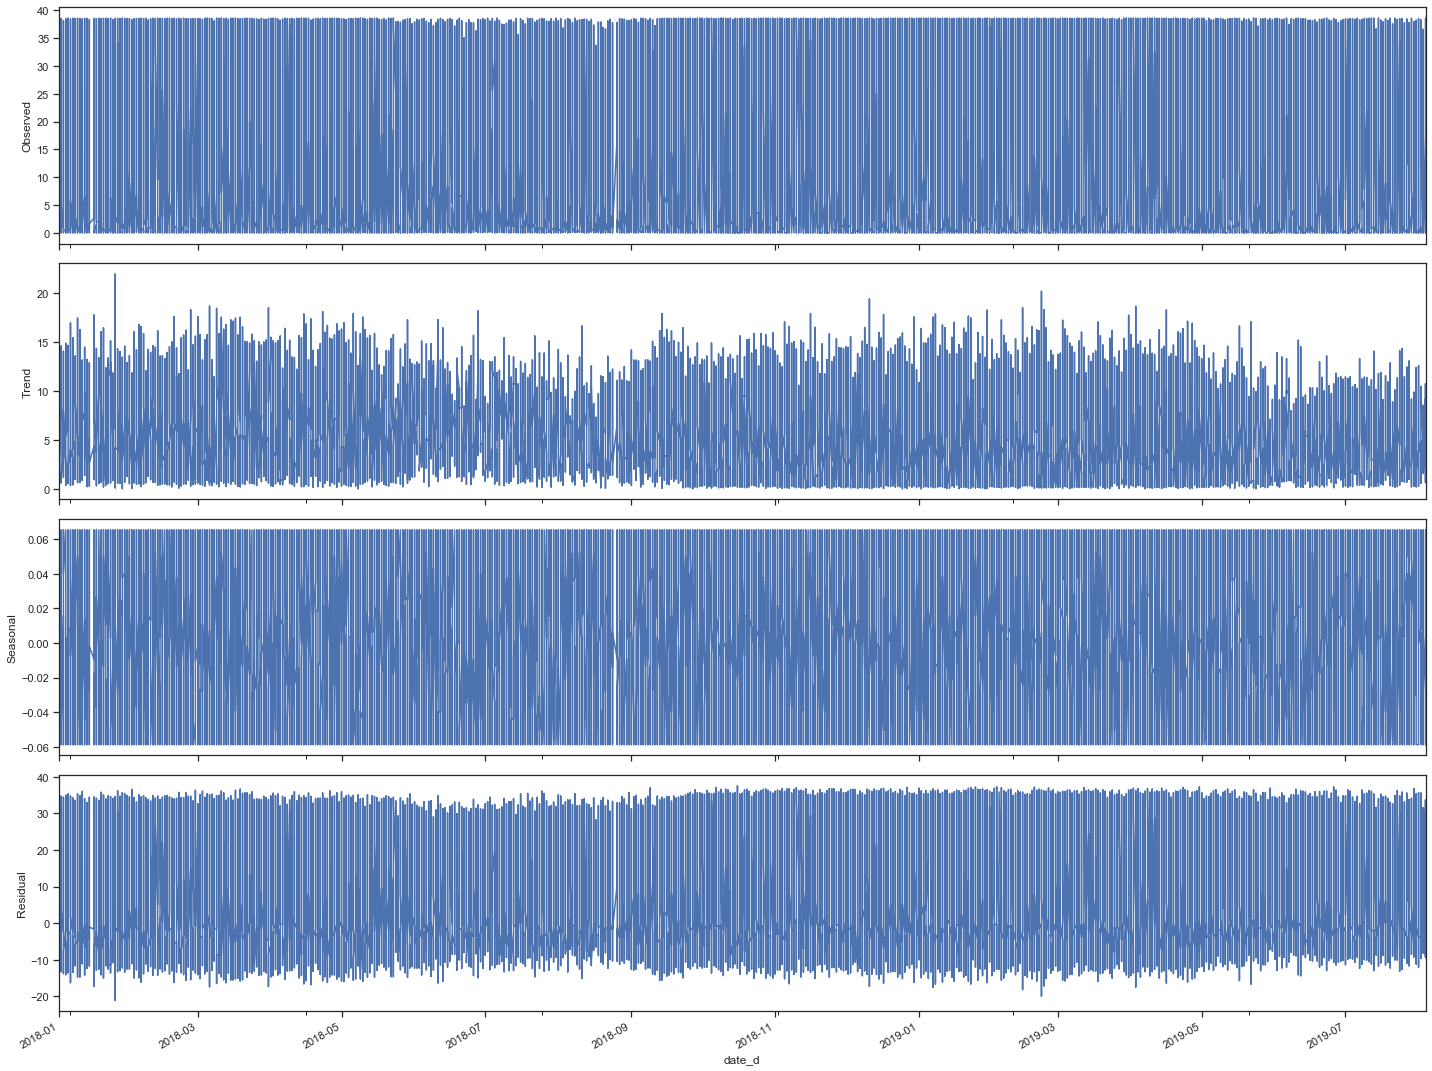

In [19]:
rcParams['figure.figsize'] = [20, 15]
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(mongoNeo[mongoNeo.score>0].score, freq=60)
result.plot()
plt.show()

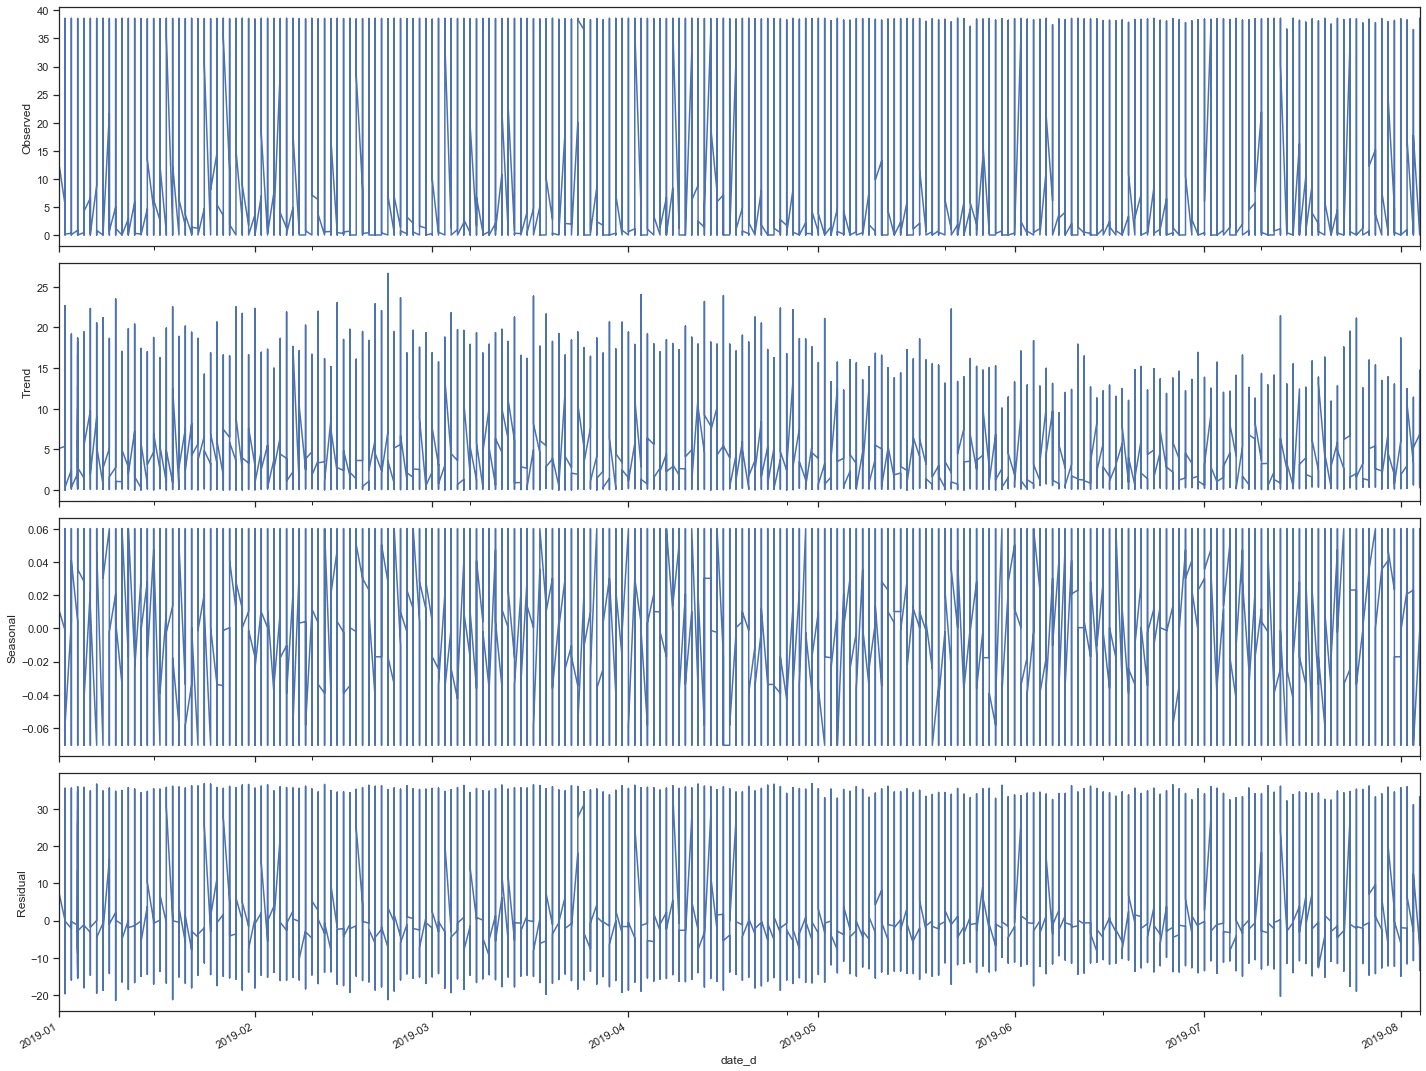

In [20]:
#mongoNeo.reset_index(inplace=True)
#mongoNeo = mongoNeo.set_index('date_d')
result = seasonal_decompose(mongoNeo[(mongoNeo.score>0)
                                     &(mongoNeo.year==2019)].score, freq=30)
result.plot()
plt.show()

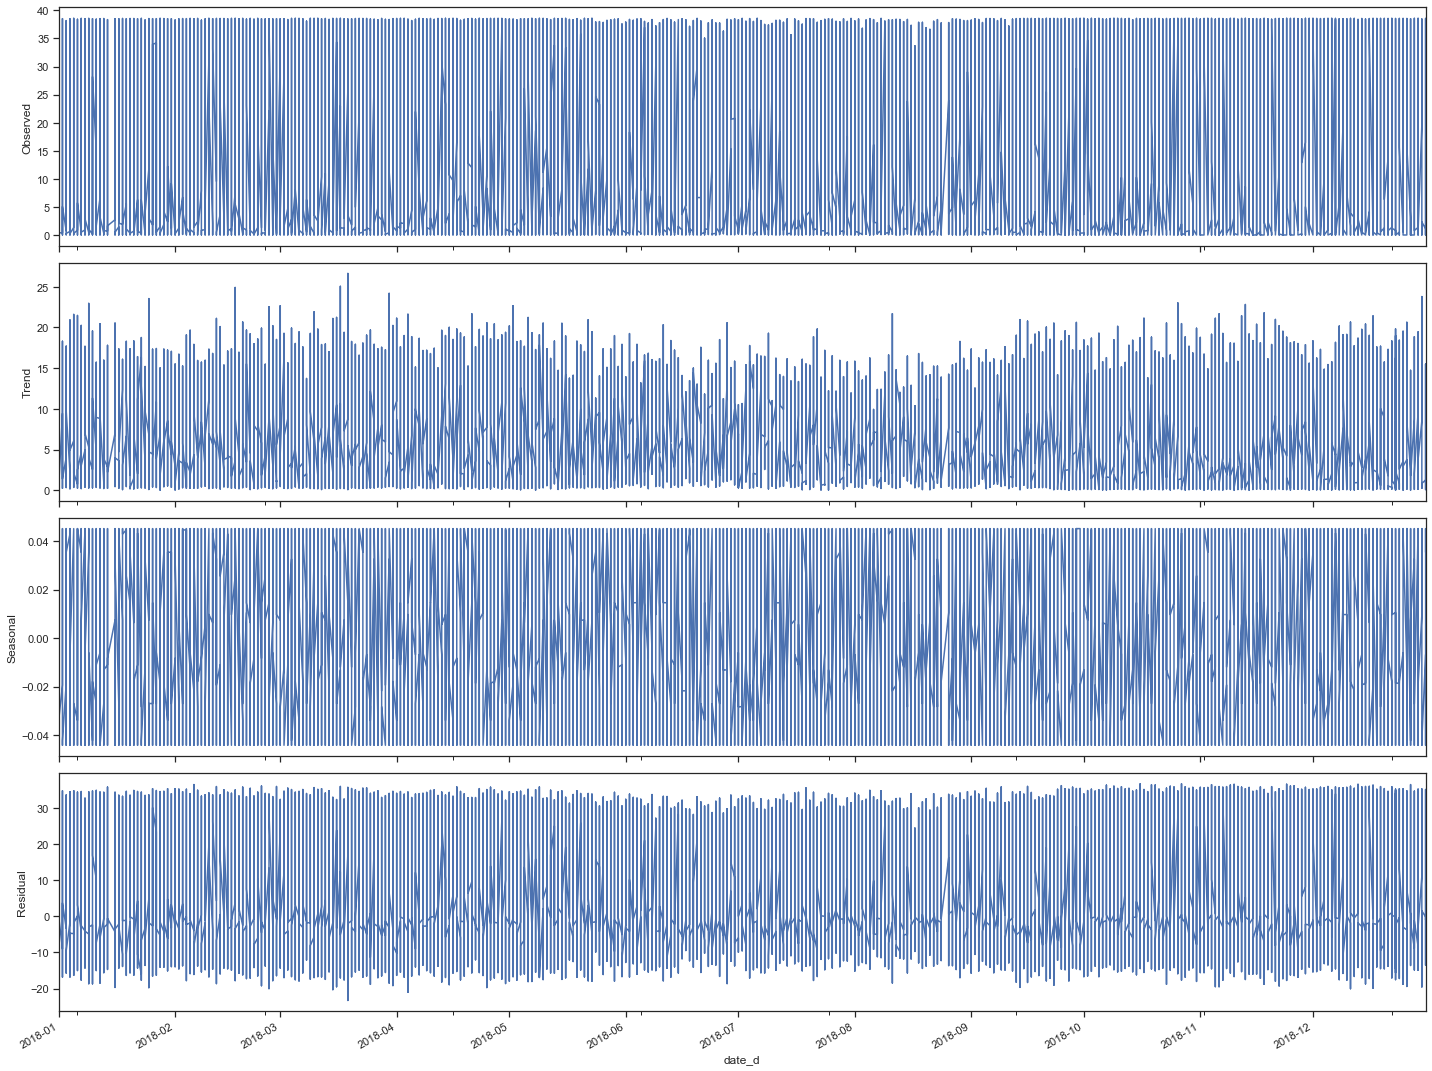

In [21]:
result = seasonal_decompose(mongoNeo[(mongoNeo.score>0)
                                     &(mongoNeo.year==2018)].score, freq=30)
result.plot()
plt.show()

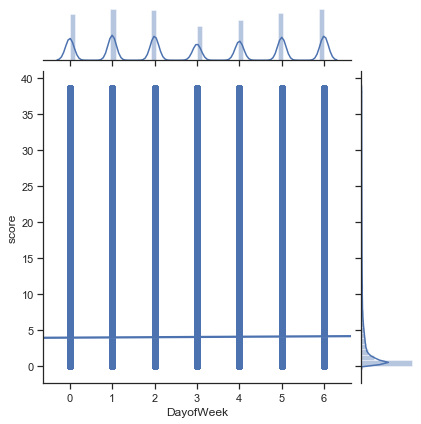

In [22]:
mongoNeo['DayofWeek'] = mongoNeo['timestamp'].dt.weekday

g = sns.JointGrid(x="DayofWeek", y="score", data=mongoNeo)
g = g.plot(sns.regplot, sns.distplot)

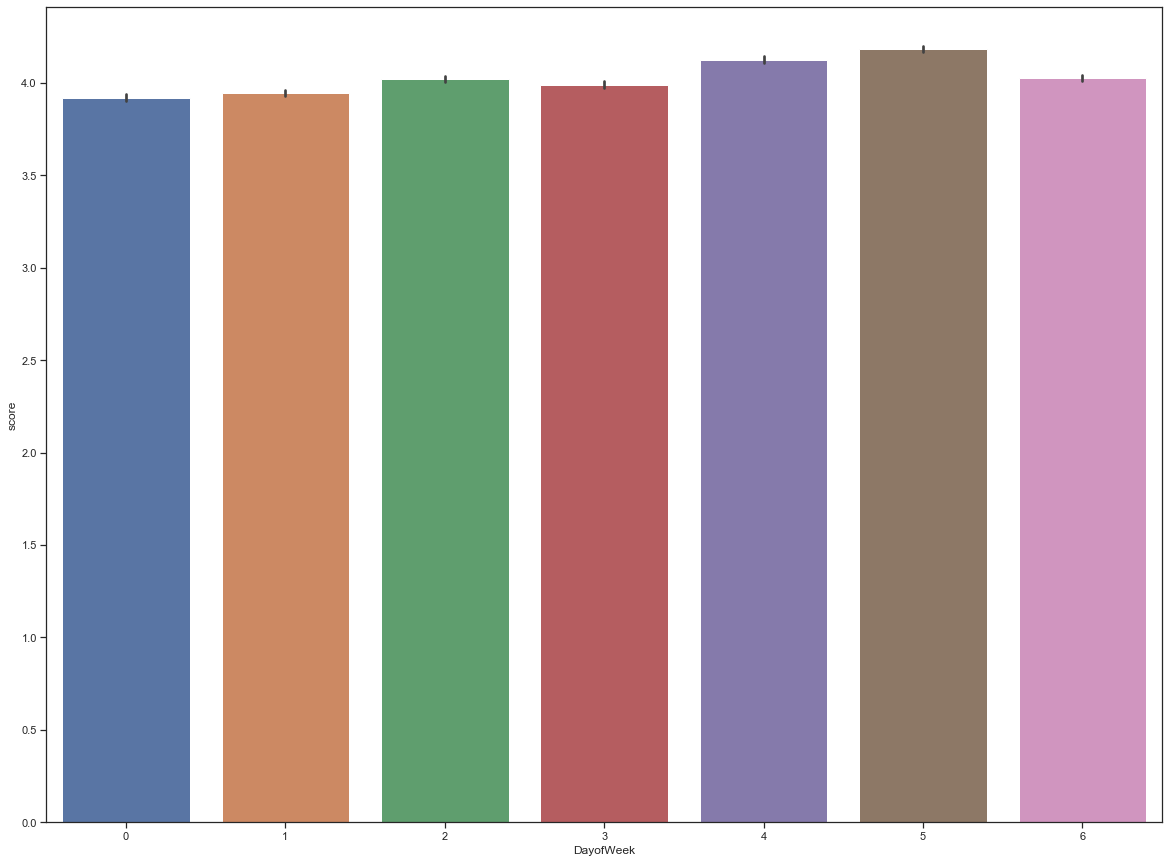

In [23]:
sns.barplot(x='DayofWeek',y='score',data=mongoNeo)

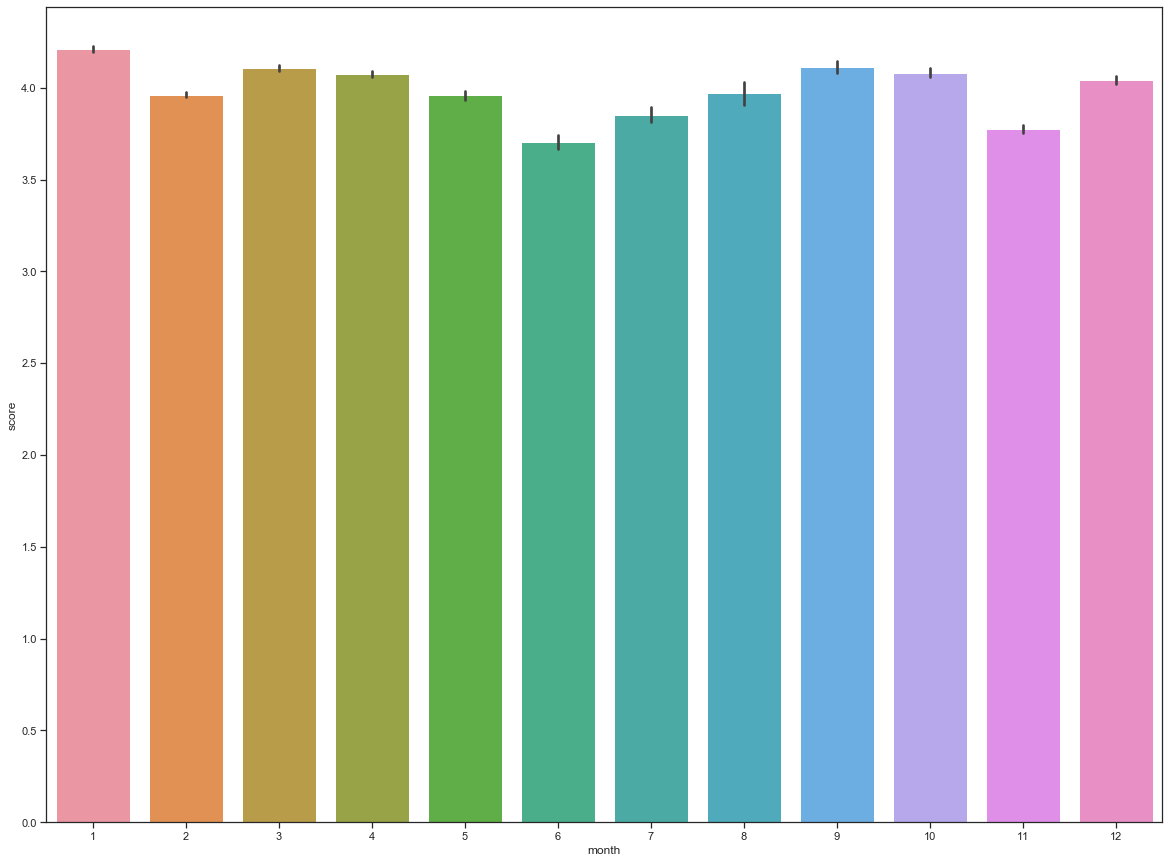

In [24]:
mongoNeo['month'] = mongoNeo['timestamp'].dt.month
sns.barplot(x='month',y='score',data=mongoNeo)

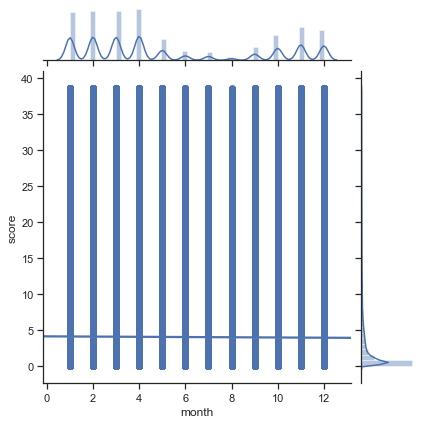

In [25]:
g = sns.JointGrid(x="month", y="score", data=mongoNeo)
g = g.plot(sns.regplot, sns.distplot)

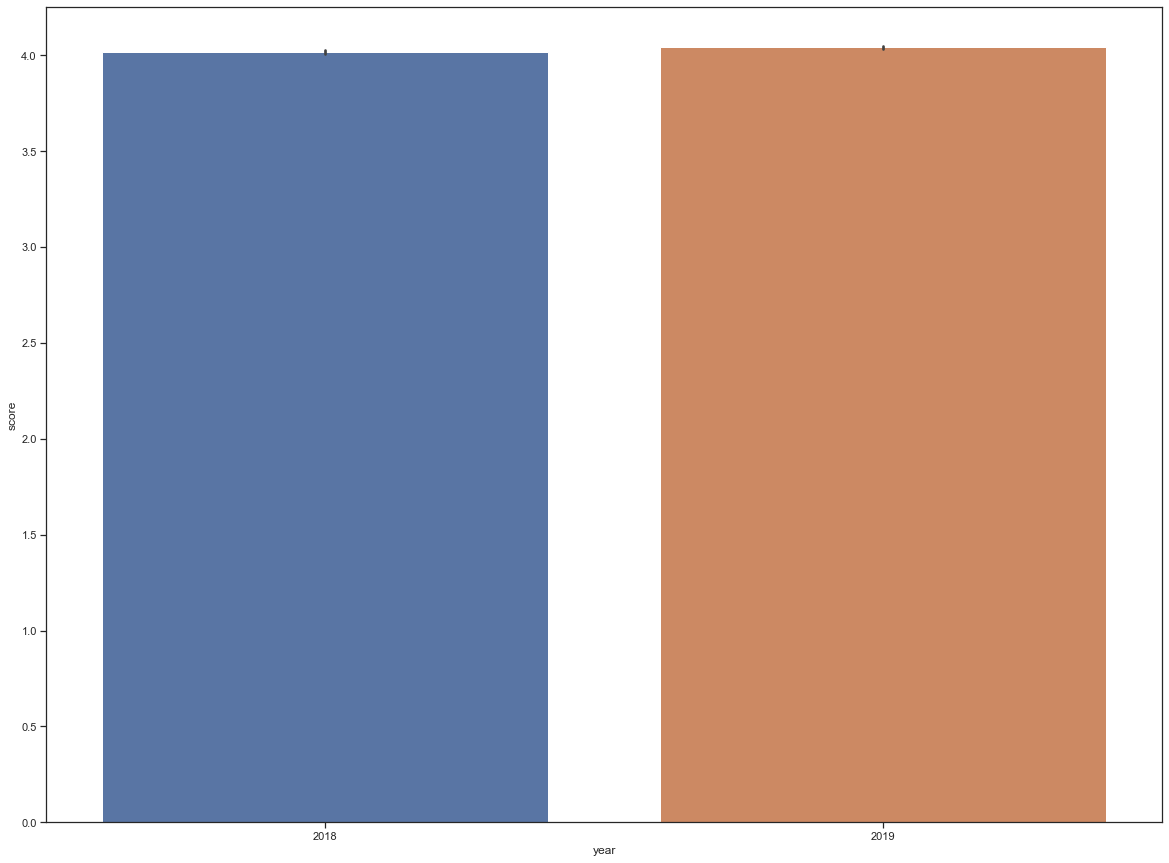

In [26]:
#mongoNeo['year'] = mongoNeo['timestamp'].dt.year
sns.barplot(x='year',y='score',data=mongoNeo)

### The naive decomposition method is a simple one, and there are more advanced decompositions available, like Seasonal and Trend decomposition using Loess or STL decomposition.

In [ ]:
mongoNeo

In [27]:
from stldecompose import decompose
import statsmodels.api as sm

In [29]:
mongoNeo.reset_index(inplace=True)
mongoNeo['date_d1'] = mongoNeo['timestamp'].dt.to_period(freq='W-SAT')
mongoNeo.set_index('date_d1', inplace=True)
mongoNeo.index = mongoNeo.index.to_timestamp()

In [30]:
obs = (mongoNeo['score']
       .resample('D')
       .mean()
       .interpolate('linear'))

In [31]:
decomp = decompose(obs, period=365)

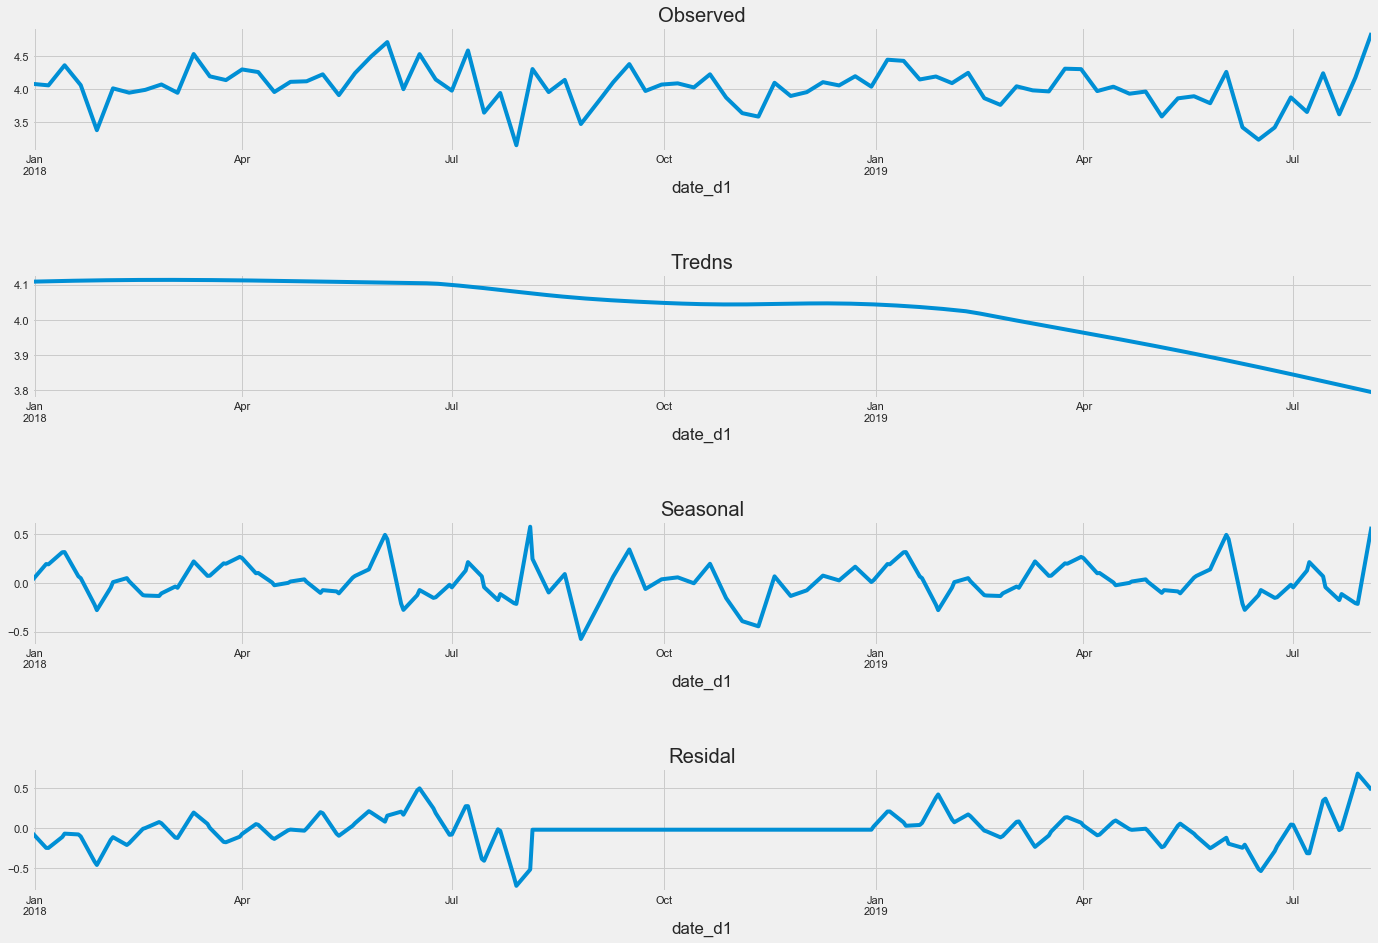

In [32]:
plt.style.use('fivethirtyeight')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(24,15))
fig.subplots_adjust(wspace=1,
 hspace=1,
 left=0.125,
 right=0.9,
 top=0.9,
 bottom=0.1)
decomp.observed.plot(ax=ax1, title='Observed')
decomp.trend.plot(ax=ax2, title='Tredns')
decomp.seasonal.plot(ax=ax3, title='Seasonal')
decomp.resid.plot(ax=ax4, title='Residal')

In [33]:
obs = (mongoNeo[mongoNeo.year==2018]['score']
       .resample('D')
       .mean()
       .interpolate('linear'))

In [34]:
decomp = decompose(obs, period=365)

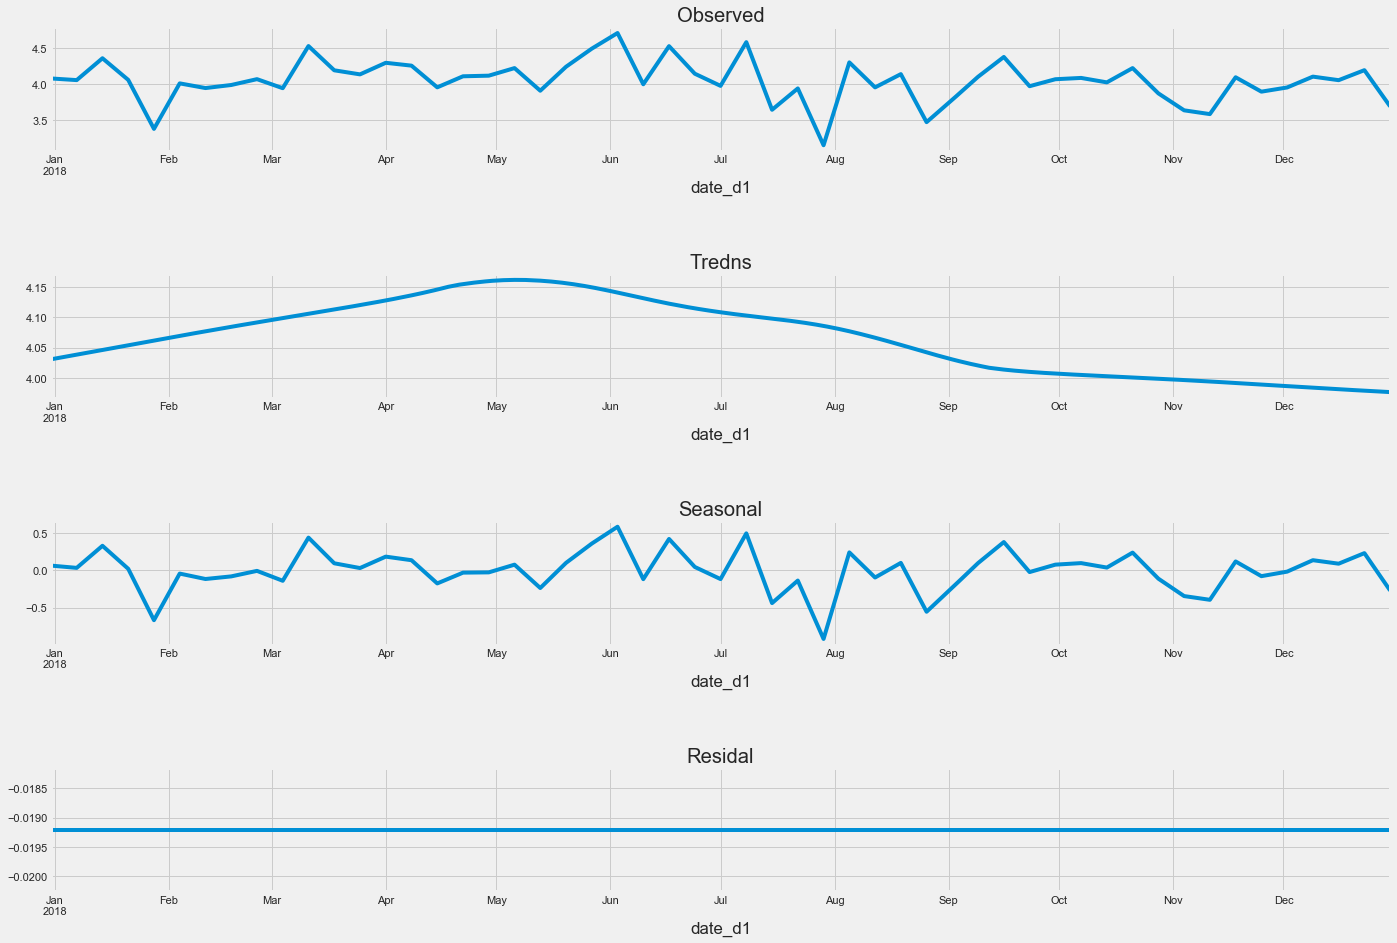

In [35]:
plt.style.use('fivethirtyeight')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(24,15))
fig.subplots_adjust(wspace=1,
 hspace=1,
 left=0.125,
 right=0.9,
 top=0.9,
 bottom=0.1)
decomp.observed.plot(ax=ax1, title='Observed')
decomp.trend.plot(ax=ax2, title='Tredns')
decomp.seasonal.plot(ax=ax3, title='Seasonal')
decomp.resid.plot(ax=ax4, title='Residal')

In [46]:
obs = (mongoNeo[(mongoNeo.year==2019)&(mongoNeo.month<6)]['score']
       .resample('D')
       .mean()
       .interpolate('linear'))

In [47]:
decomp = decompose(obs, period=365)

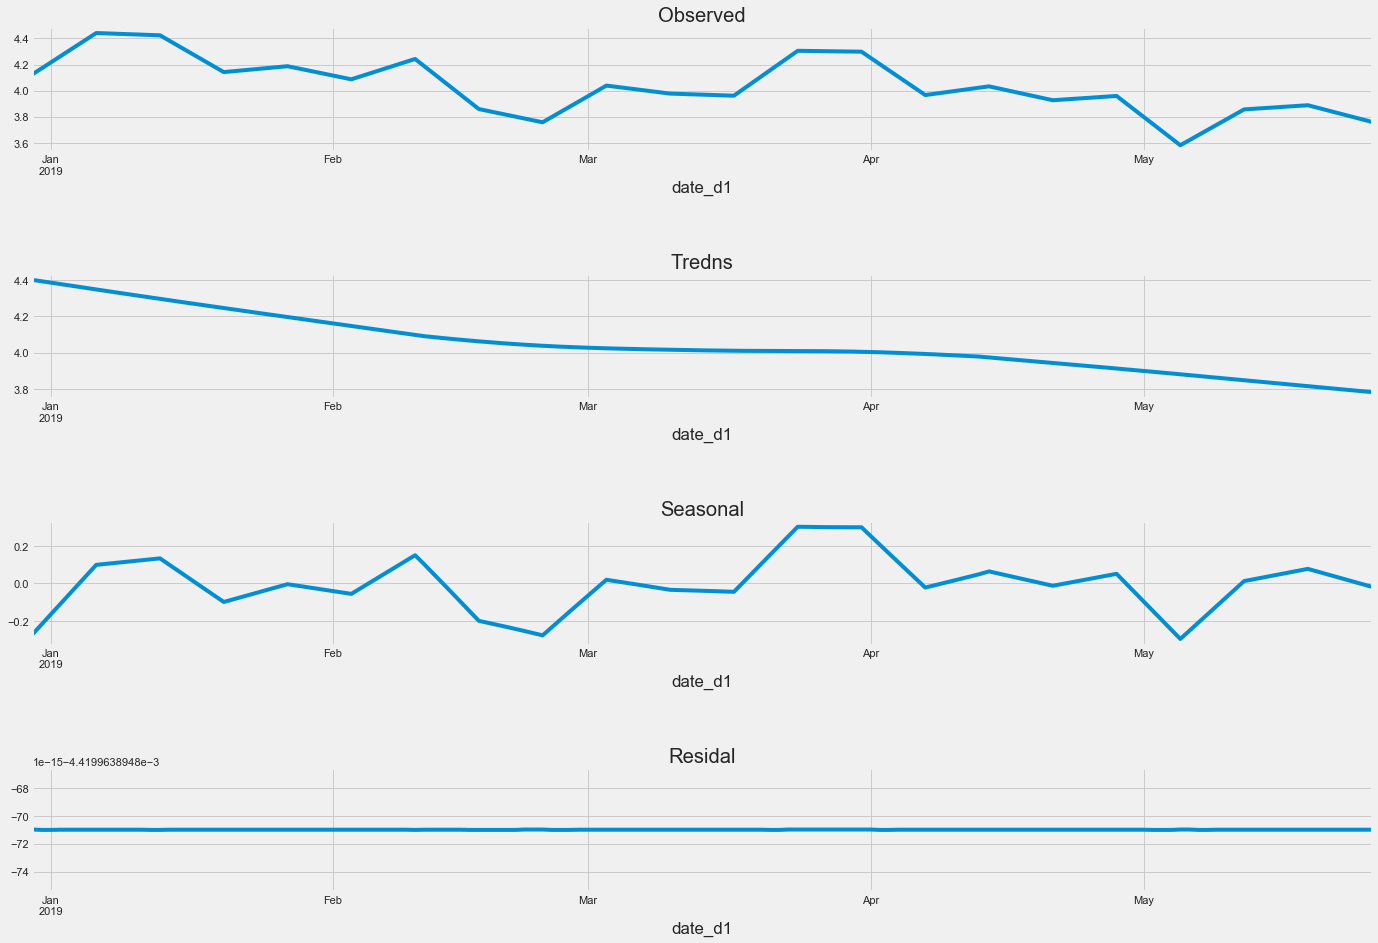

In [48]:
plt.style.use('fivethirtyeight')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(24,15))
fig.subplots_adjust(wspace=1,
 hspace=1,
 left=0.125,
 right=0.9,
 top=0.9,
 bottom=0.1)
decomp.observed.plot(ax=ax1, title='Observed')
decomp.trend.plot(ax=ax2, title='Tredns')
decomp.seasonal.plot(ax=ax3, title='Seasonal')
decomp.resid.plot(ax=ax4, title='Residal')

In [6]:
query_ = """MATCH (c:Category) 
RETURN  c.id as id_category, c.title as category"""
result = query_neo4j_db(query_)
df_category = pd.DataFrame(data=result, columns = ['id_category','category'])

In [7]:
df_category

,id_category,category
0,9lj2wk5qqj6eqgy4y,كتب عربية
1,9lj2wk5qqj6eqgy4z,موضوعات
2,9lj2wk5qqj6eqgy5a,الكائنات الحية
3,9lj2wk5qqj6eqgy5b,صحتي
4,9lj2wk5qqj6eqgy5c,البيئة والتلوث
5,9lj2wk5qqj6eqk248,المجتمع
6,9lj2wk5qqj6eqk249,لغتي
7,9lj2wk5qqj6eql6p5,العلوم
8,9lj2wk5qqj6eql6p6,الرياضيات
9,9lj2wk5qqj6eql6ph,الرياضة والهوايات


In [8]:
from googletrans import Translator # library to work with Google translator
import time # library to work with time

In [9]:
df_category['eng'] = ''

In [10]:
for i, row in df_category.iterrows():
    translator = Translator() # we create an object for translator. Cycle to create new key each time 
    # we do it because if not Google can ban us after a couple of dozens of translations
    time.sleep(3) # pause to not to be banned for spam
    text = row['category']
    tr = translator.translate(text)
    df_category.loc[i,'eng'] = tr.text

In [13]:
df_category[df_category.id_category	=='9lj2wk1vgjdhp8sy7']

,id_category,category,eng
118,9lj2wk1vgjdhp8sy7,السلوى للدراسات والنشر,Quails for Studies and Publishing


In [14]:
df_category[df_category.id_category	=='9lj2wk5qqj6eql6pi']

,id_category,category,eng
10,9lj2wk5qqj6eql6pi,القصص,Stories


In [12]:
df_category.to_csv('E:\\User\\jupyter\\data\\category.csv', index=False)